# Machine Learning for Software Analysis (MLSA)

## University of Florence -- IMT School for Advanced Studies Lucca

### Fabio Pinelli
<a href="mailto:fabio.pinelli@imtlucca.it">fabio.pinelli@imtlucca.it</a><br/>
IMT School for Advanced Studies Lucca<br/>
2025/2026<br/>
November, 10 2025

In [1]:
###########################################################
!pip install gensim==4.3.3
# The library has been archived and won't be used anymore
# # !pip install allennlp==0.9.0
!pip install flair==0.13.1
!pip install torchvision==0.18.1
# # HuggingFace

!pip uninstall -y transformers peft
!pip install transformers==4.38.0
!pip install datasets==2.18.0
!pip install peft==0.8.2
!pip install accelerate==0.30.0
###########################################################

Found existing installation: transformers 4.38.0
Uninstalling transformers-4.38.0:
  Successfully uninstalled transformers-4.38.0
Found existing installation: peft 0.8.2
Uninstalling peft-0.8.2:
  Successfully uninstalled peft-0.8.2
  Using cached transformers-4.38.0-py3-none-any.whl.metadata (131 kB)
Using cached transformers-4.38.0-py3-none-any.whl (8.5 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.0 which is incompatible.
  Using cached peft-0.8.2-py3-none-any.whl.metadata (25 kB)
Using cached peft-0.8.2-py3-none-any.whl (183 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.11.0
    Uninstalling accelerate-1.11.0:
      Successfully uninstalle

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter11()
# This is needed to render the plots in this chapter
from plots.chapter11 import *

Finished!


In [3]:
import os
import json
import errno
import requests
import numpy as np
from copy import deepcopy
from operator import itemgetter

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset

from data_generation.nlp import ALICE_URL, WIZARD_URL, download_text
from stepbystep.v4 import StepByStep
# These are the classes we built in previous class 10
from seq2seq import *

import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import gensim
from gensim import corpora, downloader
from gensim.parsing.preprocessing import *
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

In [5]:
from flair.data import Sentence
#from flair.embeddings import ELMoEmbeddings, WordEmbeddings, \
#    TransformerWordEmbeddings, TransformerDocumentEmbeddings
from flair.embeddings import WordEmbeddings, \
    TransformerWordEmbeddings, TransformerDocumentEmbeddings

In [6]:
from datasets import load_dataset, Split
from transformers import (
    DataCollatorForLanguageModeling,
    BertModel, BertTokenizer, BertForSequenceClassification,
    DistilBertModel, DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoModelForSequenceClassification,
    AutoModel, AutoTokenizer, AutoModelForCausalLM,
    Trainer, TrainingArguments, pipeline, TextClassificationPipeline
)
from transformers.pipelines import SUPPORTED_TASKS

# Down the Yellow Brick Rabbit Hole

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/alice_dorothy.png?raw=1)

*Left: "Alice and the Baby Pig" illustration by John Tenniel's, from "Alice's Adventure's in Wonderland" (1865).*

*Right: "Dorothy meets the Cowardly Lion" illustration by W.W. Denslow, from "The Wonderful Wizard of Oz" (1900)*

## Classification task

- Given a sentence we want to classify if this is written into *ALICE'S ADVENTURES IN WONDERLAN* or *The wonderful Wizard of Oz*.

- This is a Natural Language Processing (NLP) task.

- We explore how to handle word that are not numbers. How we can use them to learn and train a model and use it in various tasks.

- Tokenization, Embeddings, Bert, ChatGPT...

- Some references to understand what we do in Software Analysis with ML (you can find them also on our repository)

https://arxiv.org/pdf/2002.08155


https://arxiv.org/abs/1803.09473


https://dl.acm.org/doi/pdf/10.1145/3460348

# Building a Dataset

In [7]:
localfolder = 'texts'
download_text(ALICE_URL, localfolder)
download_text(WIZARD_URL, localfolder)

In [8]:
with open(os.path.join(localfolder, 'alice28-1476.txt'), 'r') as f:
    alice = ''.join(f.readlines()[104:3704])

with open(os.path.join(localfolder, 'wizoz10-1740.txt'), 'r') as f:
    wizard = ''.join(f.readlines()[310:5100])

In [9]:
print(alice[:500])
print('\n')
print(wizard[:500])

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 2.8




                            CHAPTER I

                      Down the Rabbit-Hole


  Alice was beginning to get very tired of sitting by her sister
on the bank, and of having nothing to do:  once or twice she had
peeped into the book her sister was reading, but it had no
pictures or conversations in it, `and what is the use of a book,'
thought Alice `w


                    THE WONDERFUL WIZARD OF OZ


                          1.  The Cyclone


    Dorothy lived in the midst of the great Kansas prairies, with
Uncle Henry, who was a farmer, and Aunt Em, who was the farmer's
wife.  Their house was small, for the lumber to build it had to be
carried by wagon many miles.  There were four walls, a floor and a
roof, which made one room; and this room contained a rusty looking
cookstove, a cupboard for the dishes, a table, three or four
chairs, and


You can explore the content of the downloaded text on Colab left panel [folder icon] and you could see that the initial part of both books contains useless text for our purposes.

We write a cfg file that contains the lines to be considered then we will proceed on identifying sentences in the books that will be our training dataset

In [10]:
text_cfg = """fname,start,end
alice28-1476.txt,104,3704
wizoz10-1740.txt,310,5100"""
bytes_written = open(os.path.join(localfolder, 'lines.cfg'), 'w').write(text_cfg)

### Setting the goals

Our goal is to **transform** the books in CSV files so that they can be read as datasets.

Each line of the CSV will have a line for each sentence of the book, so that we could try to classify them, accordingly.

Something like:
```
sentence,source
"dsf sdf sdfsd sdfs, sdfs: dsfsdf, sdfs", Alice
"ipopsd iops siopiopi sdoiop sdifop", Alice
"mnmnb nmmnnj jj kjkj; \"jkj jk jk, ", Alice
"qweq qweq qweqw, qweqe ,\"qweqwe w,qwe,w\" ", Alice
```

## Sentence Tokenization

You might have already met the words **token** and **tokenization**
- A **token** is a piece of text
- Tokenize a text means to split it into pieces (token), getting as result a list of **tokens**

The most common kind of pieces is a word, typically tokenizing a text usually means to split it into words, for instance, using the **white space** a separator.

In [11]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

What about *I'm*, it should be two tokens or just one?

IT DEPENDS :-)!

We will see later how to more properly perform tokenization at the word level.

For now, we are interested in sentence tokenization, our task is to classify sentences.

In order to do that, we use a library called NLTK (Natural Language Toolkit) and it ```sent_tokenize()``` method.


```punkt``` is a pre-trained model for tokenization.

- It's based on the Punkt Sentence Tokenizer, a popular unsupervised method for sentence boundary detection.
- NLTK's punkt tokenizer can split text into sentences and further tokenize sentences into words.
- Language Support: punkt includes models trained for multiple languages (e.g., English, German, French).

In [12]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
corpus_alice = sent_tokenize(alice)
corpus_wizard = sent_tokenize(wizard)
len(corpus_alice), len(corpus_wizard)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(1612, 2240)

A **corpus** is a structured set of **Documents**.

A document can be a **sentence**, a **paragraph**, a **tweet** or a **book**.

In our case, the document is a **sentence**, so each book is actually a set of **sentences**, thus each book may be considered a corpus...

Its plural???


**CORPORA**

In [13]:
corpus_alice[2]

'There was nothing so VERY remarkable in that; nor did Alice\nthink it so VERY much out of the way to hear the Rabbit say to\nitself, `Oh dear!'

This includes ```\n```, the sentence tokenizer only handles the sentence splitting and it doesn't clean the text.

In [14]:
corpus_wizard[30]

'"There\'s a cyclone coming, Em," he called to his wife.'

The same here, we have " the quotation mark

Remember, we need to create CSV files with one sentence per line. Therefore, we need to:
- Clean the line breaks
- Define a quote char to wrap such that the original commas or semicolons are not misinteoreted as separation chars of the CSV
- add a second column (label) to identify the source

Then we will concatenate everything, shuffle the sentences before training a model

We expect to have something like this:
```
\"There's a cyclone coming, Em," he called to his wife.\,wizoz10-1740.txt
```
Where the **escape** character "**\**" is the quote char because is not present in any (novel) books.

Different choices has to be done when we will deal with code data.

In [15]:
def sentence_tokenize(source, quote_char='\\', sep_char=',',
                      include_header=True, include_source=True,
                      extensions=('txt'), **kwargs):
    nltk.download('punkt')
    # If source is a folder, goes through all files inside it
    # that match the desired extensions ('txt' by default)
    if os.path.isdir(source):
        filenames = [f for f in os.listdir(source)
                     if os.path.isfile(os.path.join(source, f)) and
                        os.path.splitext(f)[1][1:] in extensions]
    elif isinstance(source, str):
        filenames = [source]

    # If there is a configuration file, builds a dictionary with
    # the corresponding start and end lines of each text file
    config_file = os.path.join(source, 'lines.cfg')
    config = {}
    if os.path.exists(config_file):
        with open(config_file, 'r') as f:
            rows = f.readlines()

        for r in rows[1:]:
            fname, start, end = r.strip().split(',')
            config.update({fname: (int(start), int(end))})

    new_fnames = []
    # For each file of text
    for fname in filenames:
        # If there's a start and end line for that file, use it
        try:
            start, end = config[fname]
        except KeyError:
            start = None
            end = None

        # Opens the file, slices the configures lines (if any)
        # cleans line breaks and uses the sentence tokenizer
        with open(os.path.join(source, fname), 'r') as f:
            contents = (''.join(f.readlines()[slice(start, end, None)])
                        .replace('\n', ' ').replace('\r', ''))
        corpus = sent_tokenize(contents, **kwargs)

        # Builds a CSV file containing tokenized sentences
        base = os.path.splitext(fname)[0]
        new_fname = f'{base}.sent.csv'
        new_fname = os.path.join(source, new_fname)
        with open(new_fname, 'w') as f:
            # Header of the file
            if include_header:
                if include_source:
                    f.write('sentence,source\n')
                else:
                    f.write('sentence\n')
            # Writes one line for each sentence
            for sentence in corpus:
                if include_source:
                    f.write(f'{quote_char}{sentence}{quote_char}{sep_char}{fname}\n')
                else:
                    f.write(f'{quote_char}{sentence}{quote_char}\n')
        new_fnames.append(new_fname)

    # Returns list of the newly generated CSV files
    return sorted(new_fnames)

The function above:
- takes a folder and goes through the file with the right extension
- it removes the lines based on a ```.cfg``` file (if any)
- it applies the sentence tokenizer to each file
- it generates the corresponding CSV files of sentences using the configured ```quote_char``` and ```sep_char```
- it names the CSV files for each original file by dropping the extension and appending ```.sent.csv``` to it.

In [16]:
new_fnames = sentence_tokenize(localfolder)
new_fnames

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['texts/alice28-1476.sent.csv', 'texts/wizoz10-1740.sent.csv']

Each CSV file contains the sentences of a book and we will use them to build our dataset (concatenating and shuffling)

## HuggingFace's Dataset

## Loading a Dataset

Instead of using regular PyTorch ```Dataset``` we use **Hugging face*** ```Dataset```.

In order to accomplish our task, we will use a pre-trained method coming from hugging face.

### Hugging face

Hugging Face is a company and open-source platform focused on making advanced machine learning, particularly natural language processing (NLP), more accessible and easier to use. It’s widely recognized for its transformer library and model hub, which provide pre-trained models and tools to streamline the use of state-of-the-art AI models in applications.

Here are the key aspects of Hugging Face:

1. Transformers Library
Hugging Face’s transformers library is one of the most popular libraries for NLP and beyond, offering access to hundreds of pre-trained models like BERT, GPT, RoBERTa, T5, and many others.
It allows users to load and fine-tune these models for tasks like text classification, translation, summarization, question answering, text generation, and more.
The library supports multiple deep learning frameworks, primarily PyTorch and TensorFlow, and includes APIs that make it easy to switch between them.

2. Model Hub
The Hugging Face Model Hub is a repository and sharing platform for machine learning models. It hosts thousands of pre-trained models contributed by both Hugging Face and the community.
Users can find, share, and download models for various tasks (not limited to NLP, but also including computer vision, audio, and more).
The hub allows seamless model access via model IDs that can be loaded directly into the transformers library, enabling rapid experimentation and deployment.

3. Datasets Library
Hugging Face’s datasets library provides a large collection of datasets for NLP, computer vision, and audio tasks. It includes popular datasets like IMDB, SQuAD, and ImageNet.
It supports streaming, efficient data handling, and pre-processing tools, making it easier to train models on large datasets.

In [17]:
from datasets import load_dataset, Split

dataset = load_dataset(path='csv', data_files=new_fnames, quotechar='\\', split=Split.TRAIN)

Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
type(dataset)

datasets.arrow_dataset.Dataset

What we have done?

We created a hugging face's dataset, specifying:
1. the type of script we are using to process the data ```path='csv'```
2. the path where the files are located ```data_files=new_fnames```
3. the quotation mark
4. the split we are generating (TRAIN)

### Attributes

In [19]:
dataset.features, dataset.num_columns, dataset.shape

({'sentence': Value(dtype='string', id=None),
  'source': Value(dtype='string', id=None)},
 2,
 (3852, 2))

Our dataset contains **2** columns (sentence, source) and there are 3852 sentences on it.

In [20]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt'}

In [21]:
dataset['source'][:3] ## we didnt' shuffle yet

['alice28-1476.txt', 'alice28-1476.txt', 'alice28-1476.txt']

### Methods of ```Dataset```
- unique, to compute for instance, the unique sources
- map, to create new columns by using a function

In [22]:
dataset.unique('source')

['alice28-1476.txt', 'wizoz10-1740.txt']

In [23]:

def is_alice_label(row):
    is_alice = int(row['source'] == 'alice28-1476.txt')
    return {'labels': is_alice}

dataset = dataset.map(is_alice_label)

Map:   0%|          | 0/3852 [00:00<?, ? examples/s]

We create a new column for label and it is already applied to the dataset

In [24]:
dataset[2]

{'sentence': 'There was nothing so VERY remarkable in that; nor did Alice think it so VERY much out of the way to hear the Rabbit say to itself, `Oh dear!',
 'source': 'alice28-1476.txt',
 'labels': 1}

In [25]:
shuffled_dataset = dataset.shuffle(seed=42)

In [26]:
split_dataset = shuffled_dataset.train_test_split(test_size=0.2)
split_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 3081
    })
    test: Dataset({
        features: ['sentence', 'source', 'labels'],
        num_rows: 771
    })
})

In [27]:
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

In [28]:
train_dataset.features

{'sentence': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'labels': Value(dtype='int64', id=None)}

# Word Tokenization

Now we have the dataset structured with all the information we need.

But the basic bricks of NLP tasks are the words, and we need to process them...

We already see a simple word tokenizer that uses the white space as separator, but this doesn't work well as we want.

In [29]:
sentence = "I'm following the white rabbit"
tokens = sentence.split(' ')
tokens

["I'm", 'following', 'the', 'white', 'rabbit']

We can use another library ```gensim``` that can help us on this task.

We could use the NLKT tokenizer, but Gensim includes interesting tools that we can use later, but doesn't have a sentence tokenizer... and also it is a way to know different libraries :-)  

In [30]:
from gensim.parsing.preprocessing import *

preprocess_string(sentence)

['follow', 'white', 'rabbit']

```def preprocess_string(s, filters=DEFAULT_FILTERS)```
Apply list of chosen filters to s.

Default list of filters:
```
~gensim.parsing.preprocessing.strip_tags,
~gensim.parsing.preprocessing.strip_punctuation,
~gensim.parsing.preprocessing.strip_multiple_whitespaces,
~gensim.parsing.preprocessing.strip_numeric,
~gensim.parsing.preprocessing.remove_stopwords,
~gensim.parsing.preprocessing.strip_short,
~gensim.parsing.preprocessing.stem_text.
```
**Parameters**
s : str
filters: list of functions, optional

**Returns**
list of str
    Processed strings (cleaned).



We keep the list of filters limited: lower case, tags, punctuactions, multiple white spaces and numeric.

You can play on your own with the filters and check the obtained results...

In [31]:
filters = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]
preprocess_string(sentence, filters=filters)

['i', 'm', 'following', 'the', 'white', 'rabbit']

Another option is to use ```simple_preprocess``` method that limit the filters to:
- lower case
- remove tokens too short (less than 3 chars)
- remove tokens too long (more than 15 chars)

In [32]:
from gensim.utils import simple_preprocess

tokens = simple_preprocess(sentence)
tokens

['following', 'the', 'white', 'rabbit']

## Vocabulary

Once we have the token, a list of words, we can build our vocabulary, a list of unique words that appear in the text corpora.

In [33]:
sentences = train_dataset['sentence'] ## we take the column sentence
tokens = [simple_preprocess(sent) for sent in sentences] # for each sentence we extract the tokens
tokens[0]

['the',
 'winkies',
 'were',
 'sorry',
 'to',
 'have',
 'them',
 'go',
 'and',
 'they',
 'had',
 'grown',
 'so',
 'fond',
 'of',
 'the',
 'tin',
 'woodman',
 'that',
 'they',
 'begged',
 'him',
 'to',
 'stay',
 'and',
 'rule',
 'over',
 'them',
 'and',
 'the',
 'yellow',
 'land',
 'of',
 'the',
 'west']

In [34]:
'''
Once we have the token we can build our vocabulary, a list of unique words that appear in the text corpora.
'''

from gensim import corpora

dictionary = corpora.Dictionary(tokens)
print(dictionary)

Dictionary<3721 unique tokens: ['and', 'begged', 'fond', 'go', 'grown']...>


The Dictionary object computes some specific attributes

In [35]:
dictionary.num_docs

3081

In [36]:
dictionary.num_pos # processed words

50727

In [37]:
dictionary.token2id

{'and': 0,
 'begged': 1,
 'fond': 2,
 'go': 3,
 'grown': 4,
 'had': 5,
 'have': 6,
 'him': 7,
 'land': 8,
 'of': 9,
 'over': 10,
 'rule': 11,
 'so': 12,
 'sorry': 13,
 'stay': 14,
 'that': 15,
 'the': 16,
 'them': 17,
 'they': 18,
 'tin': 19,
 'to': 20,
 'were': 21,
 'west': 22,
 'winkies': 23,
 'woodman': 24,
 'yellow': 25,
 'brains': 26,
 'give': 27,
 'good': 28,
 'he': 29,
 'how': 30,
 'knew': 31,
 'me': 32,
 'said': 33,
 'scarecrow': 34,
 'too': 35,
 'very': 36,
 'about': 37,
 'again': 38,
 'alice': 39,
 'as': 40,
 'do': 41,
 'find': 42,
 'first': 43,
 'garden': 44,
 'got': 45,
 'grow': 46,
 'herself': 47,
 'in': 48,
 'into': 49,
 'is': 50,
 'lovely': 51,
 'my': 52,
 'right': 53,
 'second': 54,
 'she': 55,
 'size': 56,
 'thing': 57,
 've': 58,
 'wandered': 59,
 'way': 60,
 'wood': 61,
 'after': 62,
 'deal': 63,
 'for': 64,
 'get': 65,
 'great': 66,
 'hard': 67,
 'heavy': 68,
 'lion': 69,
 'managed': 70,
 'on': 71,
 'truck': 72,
 'up': 73,
 'was': 74,
 'work': 75,
 'yes': 76,
 'let'

In [38]:
vocab = list(dictionary.token2id.keys())
vocab[:5]

['and', 'begged', 'fond', 'go', 'grown']

In [39]:
#collection frequencies, how many times a given token appears in the corpora
dictionary.cfs

{16: 3650,
 23: 22,
 21: 238,
 13: 12,
 20: 1445,
 6: 191,
 17: 264,
 3: 106,
 0: 2027,
 18: 426,
 5: 362,
 4: 11,
 12: 354,
 2: 6,
 9: 1068,
 19: 113,
 24: 150,
 15: 560,
 1: 2,
 7: 181,
 14: 6,
 11: 12,
 10: 110,
 25: 24,
 8: 31,
 22: 19,
 29: 463,
 31: 31,
 30: 110,
 27: 38,
 32: 202,
 26: 44,
 36: 181,
 28: 104,
 35: 48,
 33: 634,
 34: 186,
 43: 78,
 57: 61,
 58: 42,
 45: 49,
 41: 176,
 39: 316,
 47: 86,
 40: 470,
 55: 783,
 59: 2,
 37: 114,
 48: 696,
 61: 14,
 50: 298,
 46: 9,
 52: 200,
 53: 46,
 56: 11,
 38: 139,
 54: 6,
 42: 36,
 60: 93,
 49: 123,
 51: 16,
 44: 14,
 62: 94,
 66: 138,
 63: 14,
 67: 23,
 75: 25,
 64: 382,
 69: 146,
 74: 689,
 68: 6,
 70: 7,
 65: 94,
 73: 166,
 71: 284,
 72: 9,
 76: 26,
 77: 36,
 78: 720,
 81: 8,
 87: 7,
 90: 4,
 88: 41,
 92: 44,
 91: 5,
 82: 4,
 83: 7,
 80: 118,
 89: 184,
 85: 1,
 79: 12,
 86: 261,
 84: 64,
 96: 20,
 93: 24,
 98: 67,
 101: 146,
 100: 104,
 97: 3,
 95: 30,
 99: 50,
 94: 2,
 108: 177,
 102: 296,
 104: 74,
 105: 9,
 106: 47,
 107: 24

In [40]:
# in how many documents a token appears
dictionary.dfs

{16: 1873,
 23: 22,
 21: 206,
 13: 12,
 20: 1066,
 6: 179,
 17: 234,
 3: 104,
 0: 1300,
 18: 328,
 5: 312,
 4: 11,
 12: 338,
 2: 6,
 9: 812,
 19: 113,
 24: 147,
 15: 496,
 1: 2,
 7: 155,
 14: 6,
 11: 12,
 10: 107,
 25: 24,
 8: 31,
 22: 18,
 29: 364,
 31: 30,
 30: 102,
 27: 38,
 32: 181,
 26: 41,
 36: 170,
 28: 97,
 35: 46,
 33: 623,
 34: 186,
 43: 76,
 57: 59,
 58: 38,
 45: 48,
 41: 172,
 39: 307,
 47: 79,
 40: 334,
 55: 512,
 59: 2,
 37: 112,
 48: 598,
 61: 14,
 50: 265,
 46: 7,
 52: 181,
 53: 46,
 56: 11,
 38: 135,
 54: 6,
 42: 36,
 60: 92,
 49: 115,
 51: 15,
 44: 14,
 62: 93,
 66: 136,
 63: 14,
 67: 22,
 75: 24,
 64: 353,
 69: 145,
 74: 548,
 68: 6,
 70: 7,
 65: 92,
 73: 158,
 71: 267,
 72: 9,
 76: 26,
 77: 36,
 78: 552,
 81: 8,
 87: 5,
 90: 4,
 88: 41,
 92: 43,
 91: 5,
 82: 4,
 83: 7,
 80: 117,
 89: 175,
 85: 1,
 79: 12,
 86: 212,
 84: 63,
 96: 19,
 93: 23,
 98: 67,
 101: 142,
 100: 102,
 97: 3,
 95: 30,
 99: 50,
 94: 2,
 108: 171,
 102: 291,
 104: 73,
 105: 9,
 106: 47,
 107: 24,


In [41]:
'''
We can convert a list of tokens into a list of their correspoing indices in
the vocabulary.
'''


sentence = 'follow the white rabbit'
new_tokens = simple_preprocess(sentence)
ids = dictionary.doc2idx(new_tokens)
print(new_tokens)
print(ids)

['follow', 'the', 'white', 'rabbit']
[805, 16, 827, 822]


Despite the size of our vocabulary, we need to think that there will always be a word that isn't include...

Therefore, we use special token:

- ```[UNK]``` for unknown
- ```[PAD]``` to pad the short sentences

We can add them to our voc.

In [42]:
special_tokens = {'[PAD]': 0, '[UNK]': 1}
dictionary.patch_with_special_tokens(special_tokens)

Again, we could also be interested in removing rare terms as well as 'bad words'.

Gensim has a couple of methods that can help on that:
- ```filter_extremes()```
- ```filter_tokens()```




In [43]:
def get_rare_ids(dictionary, min_freq):
    rare_ids = [t[0] for t in dictionary.cfs.items() if t[1] < min_freq]
    return rare_ids

In [44]:
'''
The code below wraps everything togheter:
it takes a list of sentences, generates the corresponding vocabulary
and it saves it
'''

def make_vocab(sentences, folder=None, special_tokens=None, vocab_size=None, min_freq=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    # tokenizes the sentences and create a Dictionary
    tokens = [simple_preprocess(sent) for sent in sentences]
    dictionary = corpora.Dictionary(tokens)
    # keeps only the most frequent words (vocab size)
    if vocab_size is not None:
        dictionary.filter_extremes(keep_n=vocab_size)
    # removes rare words (in case the vocab size still
    # includes words with low frequency)
    if min_freq is not None:
        rare_tokens = get_rare_ids(dictionary, min_freq)
        dictionary.filter_tokens(bad_ids=rare_tokens)
    # gets the whole list of tokens and frequencies
    items = dictionary.cfs.items()
    # sorts the tokens in descending order
    words = [dictionary[t[0]] for t in sorted(dictionary.cfs.items(), key=lambda t: -t[1])]
    # prepends special tokens, if any
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [45]:
make_vocab(train_dataset['sentence'], 'our_vocab/', special_tokens=['[PAD]', '[UNK]', '[SEP]', '[CLS]', '[MASK]'], min_freq=2)

## HugginFace's Tokenizer

Since we are going to use BERT, we will use the corresponding pre-trained tokenizer.

It standardize, in some sense, the input for BERT.
It has the same information as gensim, i.e., the mapping between tokens and their id, but it includes many more information.

In [46]:
'''
It takes a vocabulary as input
'''

from transformers import BertTokenizer

tokenizer = BertTokenizer('our_vocab/vocab.txt')

In [47]:
new_sentence = 'follow the white rabbit neo'
new_tokens = tokenizer.tokenize(new_sentence)
new_tokens

['follow', 'the', 'white', 'rabbit', '[UNK]']

In [48]:
new_ids = tokenizer.convert_tokens_to_ids(new_tokens)
new_ids

[1018, 5, 215, 206, 1]

In [49]:
new_ids = tokenizer.encode(new_sentence)
new_ids

[3, 1018, 5, 215, 206, 1, 2]

In [50]:
tokenizer.convert_ids_to_tokens(new_ids)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]']

In Transformer-based models, particularly BERT (Bidirectional Encoder Representations from Transformers), the [CLS] token stands for Classification token.

**Purpose of the [CLS] Token**

**Representation**: The [CLS] token is a special token added to the beginning of every input sequence in models like BERT. During training, the model learns to treat the embedding of this token as a representation of the entire sequence.

**Classification Tasks**: For tasks that involve classification (e.g., sentiment analysis, sentence classification, or Next Sentence Prediction), the final hidden state of the [CLS] token (after processing through all transformer layers) is used as a summary of the entire sequence.

**General-Purpose Embedding**: It’s often considered the “pooled” output, as it attempts to capture information from the whole sequence in a single vector. This embedding can then be passed to a classifier or other downstream layers for decision-making.


In [51]:
tokenizer.encode(new_sentence, add_special_tokens=False)

[1018, 5, 215, 206, 1]

In [52]:
tokenizer(new_sentence, add_special_tokens=False, return_tensors='pt')

{'input_ids': tensor([[1018,    5,  215,  206,    1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [53]:
sentence1 = 'follow the white rabbit neo'
sentence2 = 'no one can be told what the matrix is'
joined_sentences = tokenizer(sentence1, sentence2)
joined_sentences

{'input_ids': [3, 1018, 5, 215, 206, 1, 2, 53, 43, 83, 34, 272, 45, 5, 1, 29, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

3 level of information:
- input_ids $⇒$ OK! we know them
- token_type_ids works as sentence index
- attention_mask that corresponds to our source mask

In [54]:

print(tokenizer.convert_ids_to_tokens(joined_sentences['input_ids']))

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']


In [55]:
separate_sentences = tokenizer([sentence1, sentence2], padding=True)
separate_sentences

{'input_ids': [[3, 1018, 5, 215, 206, 1, 2, 0, 0, 0, 0], [3, 53, 43, 83, 34, 272, 45, 5, 1, 29, 2]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [56]:
print(tokenizer.convert_ids_to_tokens(separate_sentences['input_ids'][0]))
print(separate_sentences['attention_mask'][0])

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


In [57]:
first_sentences = [sentence1, 'another first sentence']
second_sentences = [sentence2, 'a second sentence here']
batch_of_pairs = tokenizer(first_sentences, second_sentences)
first_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][0])
second_input = tokenizer.convert_ids_to_tokens(batch_of_pairs['input_ids'][1])
print(first_input)
print(second_input)

['[CLS]', 'follow', 'the', 'white', 'rabbit', '[UNK]', '[SEP]', 'no', 'one', 'can', 'be', 'told', 'what', 'the', '[UNK]', 'is', '[SEP]']
['[CLS]', 'another', 'first', 'sentence', '[SEP]', '[UNK]', 'second', 'sentence', 'here', '[SEP]']


In [58]:
tokenized_dataset = tokenizer(dataset['sentence'],
                              padding=True,
                              return_tensors='pt',
                              max_length=50,
                              truncation=True)
tokenized_dataset['input_ids']

tensor([[   3,   27,    1,  ...,   91,  833,    2],
        [   3,   25,   10,  ..., 1228,    5,    2],
        [   3,   44,   13,  ...,    0,    0,    0],
        ...,
        [   3,    1,    6,  ...,    0,    0,    0],
        [   3,    6,  137,  ...,    0,    0,    0],
        [   3,    1,    1,  ...,    0,    0,    0]])

In reality, BERT uses vectors to represent the words, using a big look-up table with the token ids as indeces.

This recalls us... **EMBEDDINGS**, in this case **WORD EMBEDDINGS**, so a representation of each token (word) as a vector, a vector of numbers... The size of the vector is the dimensionality of the embeddings.

We can build the embeddings or we can learn... then we start a beautiful trip into that.

# Before Word Embeddings

## One-Hot Encoding (OHE)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ohe1.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ohe2.png?raw=1)

As you can imagine, a representation like this has some issues:
- large
- sparse (lots of zeros!!!)


## Bag of Words (BoW)

Of course, we can do better. We could, for instance, sum up the corresponding OHE vectors, disregarding any underlying structure of relationships between the words.

The result is the counts of the words appearing in the text

In [59]:
sentence = 'the white rabbit is a rabbit'
bow_tokens = simple_preprocess(sentence)
bow_tokens

['the', 'white', 'rabbit', 'is', 'rabbit']

In [60]:
bow = dictionary.doc2bow(bow_tokens)
bow

[(16, 1), (50, 1), (822, 2), (827, 1)]

Also this approach has several limitations:
- it represents the frequencies, nothing else
- the representations can be really different when we compute a similarity function (hortogonal in the case of OHE)

Language models, instead, try to explore the structure and the relationships between words

## Language Models

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank1.png?raw=1)

It is easy to fill the gap with YOU

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/fill1.png?raw=1)

What about this?

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank2.png?raw=1)


![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/fill2.png?raw=1)




## N-grams

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/ngrams.png?raw=1)

n-grams is base on pure statistics, filling the blanks using the most common sequence that matches the words precceding the blank

With a large $n$, you might get good predictions, but with many cases with 0 predictions, on the contrary you may encounter many prediction errors.

This is due to the fact that we only **look back**.

Let's try to look ahead too!

## Continuous Bag-of-Words (CBoW)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank_end.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/blank_center.png?raw=1)

It sums up (or averages) the vectors of the context words and uses it to predit the central word.

The vectors are not one-hot-encoded and have continous values.
The vector containing the continous values are called word embeddings.

We can learn these vectors..


# Word Embeddings

## Word2Vec

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/cbow.png?raw=1)

The **target** is the central word, therefore we deal with a multiclass classification problem, where the number of classes is the size of the vocabulary.

We use the context words, better their embedding vectors, as input. Therefore becoming a parameter itself of the model.

They are randomly initialized, then as the training progresses, their weights and biases are updated.

**How it works**

For each pair of the context words, and the corresponding target, the model will average the embeddings of the context and feed the result to a linear layer that will compute one logit for each word in the vocabulary


In [61]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, X):
        embeddings = self.embedding(X)
        bow = embeddings.mean(dim=1)
        logits = self.linear(bow)
        return logits

In [62]:
torch.manual_seed(42)
dummy_cbow = CBOW(vocab_size=5, embedding_size=3)
dummy_cbow.embedding.state_dict()

OrderedDict([('weight',
              tensor([[ 0.3367,  0.1288,  0.2345],
                      [ 0.2303, -1.1229, -0.1863],
                      [ 2.2082, -0.6380,  0.4617],
                      [ 0.2674,  0.5349,  0.8094],
                      [ 1.1103, -1.6898, -0.9890]]))])

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_embed.png?raw=1)

nn.Embeddings layer is a lookup table. It may be randomly initialized given the size of the vocabulary and the number of dimensions.

In [63]:
# tokens: ['is', 'barking']
dummy_cbow.embedding(torch.as_tensor([2, 3]))

tensor([[ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], grad_fn=<EmbeddingBackward0>)

Pretending we have performed a tokenization and we have the indices of our vocab, context and target

In [64]:
tiny_vocab = ['the', 'small', 'is', 'barking', 'dog']
context_words = ['the', 'small', 'is', 'barking']
target_words = ['dog']

In [65]:
batch_context = torch.as_tensor([[0, 1, 2, 3]]).long()
batch_target = torch.as_tensor([4]).long()

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_cbow.png?raw=1)

In [66]:
cbow_features = dummy_cbow.embedding(batch_context).mean(dim=1)
cbow_features

tensor([[ 0.7606, -0.2743,  0.3298]], grad_fn=<MeanBackward1>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/w2v_logits.png?raw=1)

In [67]:
logits = dummy_cbow.linear(cbow_features)
logits

tensor([[ 0.3542,  0.6937, -0.2028, -0.5873,  0.2099]],
       grad_fn=<AddmmBackward0>)

## What is an Embeddings Anyway?

It is a representation, and each dimension of the vector corresponds to an attribute/feature.

For instance, we can describe restaurants with 3 features.

We can represent the values in numbers ranging in the interval [-1,1]

... and we can compute a similarity among them, cosine?

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/rest_discrete.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/rest_continuous.png?raw=1)

In [68]:
ratings = torch.as_tensor([[.7, -.4, .7],
                           [.3, .7, -.5],
                           [.9, -.55, .8],
                           [-.3, .8, .34]]).float()
sims = torch.zeros(4, 4)
for i in range(4):
    for j in range(4):
        sims[i, j] = F.cosine_similarity(ratings[i], ratings[j], dim=0)
sims

tensor([[ 1.0000, -0.4318,  0.9976, -0.2974],
        [-0.4318,  1.0000, -0.4270,  0.3581],
        [ 0.9976, -0.4270,  1.0000, -0.3598],
        [-0.2974,  0.3581, -0.3598,  1.0000]])

<Axes: >

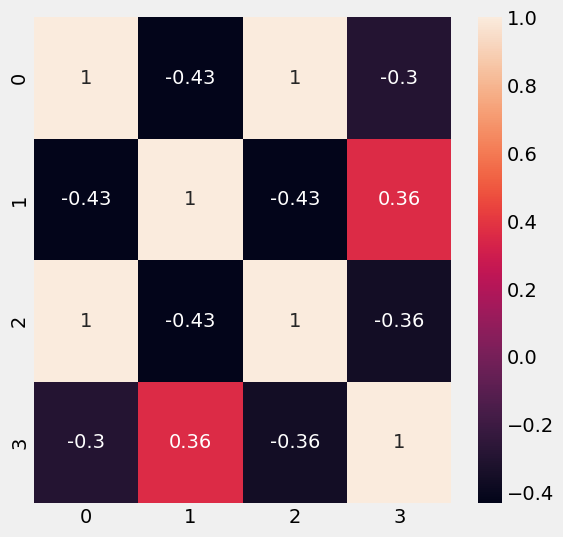

In [69]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(sims.detach().numpy(), annot=True, ax=ax)

## Pre-trained Word2Vec

In general, pretrained-word2vec models and the embeddings correspoding to a word do not have a clear meaning, but we can do fancy stuff with them.

We don't know if the $n-th$ dimension correspond to a particular "behaviour" of the word

To train word2vec that still is a simple model it requires a certain amount of data to train it.

Luckly someone already did it the job for us and for instance gensim contains a variety of pre-trained word embeddings models.

But why different models and therefore different embeddings?
Well, using different corpora produces different embeddings, since they might be influenced by the **kind of language** used in the corpora

They might depend on the model used to learn the embeddings, word2vec is one but there are many others.

## Global Vectors (GloVe)

GloVe: Global Vectors for Word Representation

It combines skip-gram model with co-occurences statistics at the **global level**

Take it for grant, if you want to know more, you can read the paper and check [https://nlp.stanford.edu/projects/glove](https://nlp.stanford.edu/projects/glove)

There are many sizes and shapes, dimensions from 25 to 300 and vocab size between 400,000 and 2,200,000 words.

In [70]:
from gensim import downloader

glove = downloader.load('glove-wiki-gigaword-50')


len(glove.key_to_index)


400000

In [71]:
glove['alice']

array([ 0.16386 ,  0.57795 , -0.59197 , -0.32446 ,  0.29762 ,  0.85151 ,
       -0.76695 , -0.20733 ,  0.21491 , -0.51587 , -0.17517 ,  0.94459 ,
        0.12705 , -0.33031 ,  0.75951 ,  0.44449 ,  0.16553 , -0.19235 ,
        0.065533, -0.12394 ,  0.61446 ,  0.89784 ,  0.17413 ,  0.41149 ,
        1.191   , -0.39461 , -0.459   ,  0.022161, -0.50843 , -0.44464 ,
        0.68721 , -0.7167  ,  0.20835 , -0.23437 ,  0.02604 , -0.47993 ,
        0.31873 , -0.29135 ,  0.50273 , -0.55144 , -0.066692,  0.43873 ,
       -0.24293 , -1.0247  ,  0.029375,  0.068499,  0.25451 , -1.9663  ,
        0.26673 ,  0.88486 ], dtype=float32)

We don't know the meaning of the dimensions, but we can do math with them

We can define the queen with the following equation:
king - man + woman = queen

In [72]:
synthetic_queen = glove['king'] - glove['man'] + glove['woman']

/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, ''])
/content/plots/chapter11.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_yticklabels(['', word, 

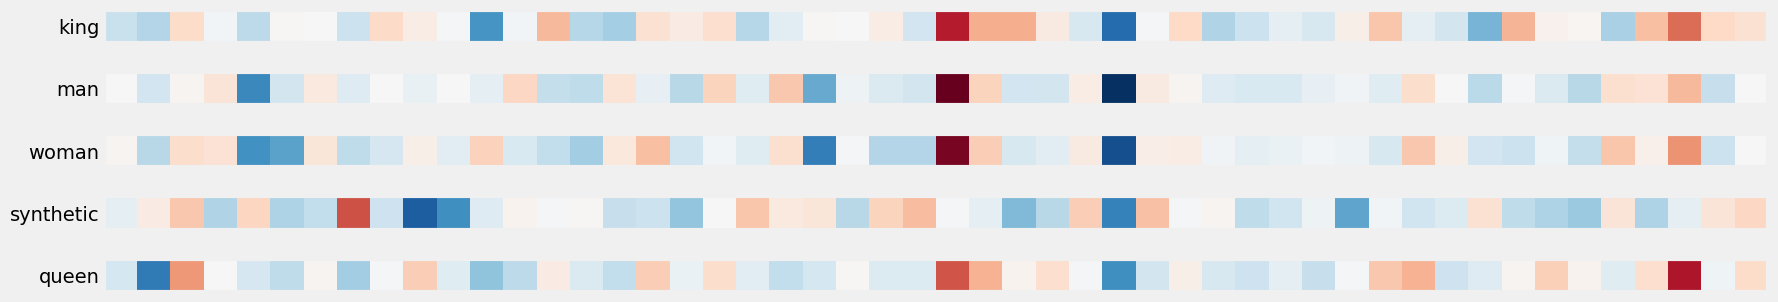

In [73]:
fig = plot_word_vectors(glove,
                        ['king', 'man', 'woman', 'synthetic', 'queen'],
                        other={'synthetic': synthetic_queen})

In [74]:
glove.similar_by_vector(synthetic_queen, topn=5)

[('king', 0.8859834671020508),
 ('queen', 0.8609582185745239),
 ('daughter', 0.7684512734413147),
 ('prince', 0.7640699744224548),
 ('throne', 0.7634970545768738)]

It's pretty common that the first results corresponds to the origin of the word embeddings arithmetic, so we can exclude it from the result... and we get queen :-)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/embed_arithmetic.png?raw=1)

$$
\Large
w_{\text{king}} - w_{\text{man}}\approx w_{\text{queen}}-w_{\text{woman}} \implies w_{\text{king}} - w_{\text{man}} + w_{\text{woman}} \approx w_{\text{queen}}
$$

It is nice and it shows that effectively the embeddings are capturing the meaning/semantics of the words.

## Using Word Embeddings

### Vocabulary Coverage

In [75]:

vocab = list(dictionary.token2id.keys())
len(vocab)

3723

In [76]:

unknown_words = sorted(list(set(vocab).difference(set(glove.key_to_index))))
###########################################################
print(len(unknown_words))
print(unknown_words[:5])

43
['[PAD]', '[UNK]', 'arrum', 'barrowful', 'beauti']


In [77]:
unknown_ids = [dictionary.token2id[w] for w in unknown_words if w not in ['[PAD]', '[UNK]']]
unknown_count = np.sum([dictionary.cfs[idx] for idx in unknown_ids])
unknown_count, dictionary.num_pos

(82, 50727)

In [78]:
def vocab_coverage(gensim_dict, pretrained_wv, special_tokens=('[PAD]', '[UNK]')):
    vocab = list(gensim_dict.token2id.keys())
    unknown_words = sorted(list(set(vocab).difference(set(pretrained_wv.key_to_index))))
    ###########################################################
    unknown_ids = [gensim_dict.token2id[w] for w in unknown_words if w not in special_tokens]
    unknown_count = np.sum([gensim_dict.cfs[idx] for idx in unknown_ids])
    cov = 1 - unknown_count / gensim_dict.num_pos
    return cov

In [79]:
vocab_coverage(dictionary, glove)

0.9983835038539633

### Tokenizer

In [80]:
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    if folder is not None:
        if not os.path.exists(folder):
            os.mkdir(folder)

    words = wv.index_to_key
    ###########################################################
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words

    with open(os.path.join(folder, 'vocab.txt'), 'w') as f:
        for word in words:
            f.write(f'{word}\n')

In [81]:
make_vocab_from_wv(glove, 'glove_vocab/', special_tokens=['[PAD]', '[UNK]'])

In [82]:
glove_tokenizer = BertTokenizer('glove_vocab/vocab.txt')

In [83]:
glove_tokenizer.encode('alice followed the white rabbit', add_special_tokens=False)

[7101, 930, 2, 300, 12427]

In [84]:
len(glove_tokenizer.vocab), len(glove.vectors)

(400002, 400000)

The difference is given by the two special tokens [PAD] and [UNK] and we can add them to our embeddings with all zeros

### Special Tokens' Embeddings

In [85]:
special_embeddings = np.zeros((2, glove.vector_size))

In [86]:
extended_embeddings = np.concatenate([special_embeddings, glove.vectors], axis=0)
extended_embeddings.shape

(400002, 50)

In [87]:
alice_idx = glove_tokenizer.encode('alice', add_special_tokens=False)
np.all(extended_embeddings[alice_idx] == glove['alice'])

True

## Model I - GloVe + Classifier

### Data Preparation

In [88]:
train_sentences = train_dataset['sentence']
train_labels = train_dataset['labels']

test_sentences = test_dataset['sentence']
test_labels = test_dataset['labels']

In [89]:
train_ids = glove_tokenizer(train_sentences,
                            truncation=True,
                            padding=True,
                            max_length=60,
                            add_special_tokens=False,
                            return_tensors='pt')['input_ids']
train_labels = torch.as_tensor(train_labels).float().view(-1, 1)

test_ids = glove_tokenizer(test_sentences,
                           truncation=True,
                           padding=True,
                           max_length=60,
                           add_special_tokens=False,
                           return_tensors='pt')['input_ids']
test_labels = torch.as_tensor(test_labels).float().view(-1, 1)

In [90]:
train_tensor_dataset = TensorDataset(train_ids, train_labels)
generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True, generator=generator)
test_tensor_dataset = TensorDataset(test_ids, test_labels)
test_loader = DataLoader(test_tensor_dataset, batch_size=32)

### Pre-Trained PyTorch Embeddings

In [91]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)

In [92]:
token_ids, labels = next(iter(train_loader))
token_ids

tensor([[    22,     17,  11158,  ...,      0,      0,      0],
        [   983,   1740,     41,  ...,      0,      0,      0],
        [   129,  11238,    404,  ...,      0,      0,      0],
        ...,
        [   102,    444,     58,  ...,      0,      0,      0],
        [    65,     37,    203,  ...,      0,      0,      0],
        [   102,     41, 163653,  ...,      0,      0,      0]])

In [93]:
token_embeddings = torch_embeddings(token_ids)
token_embeddings.shape

torch.Size([32, 60, 50])

We used the ids to get the embeddings. since we have 32 sentences, of 60 tokens with 50 dimensions each


In [94]:
token_embeddings.mean(dim=1)

tensor([[ 1.0882e-01, -1.0475e-02,  6.1110e-04,  ..., -9.9009e-02,
          1.3300e-02, -2.0037e-02],
        [ 1.4476e-01,  1.5520e-01, -6.0257e-02,  ..., -2.2813e-01,
         -4.6962e-02, -1.9464e-01],
        [ 9.8533e-03,  2.9683e-02, -1.1913e-04,  ..., -7.7648e-02,
         -1.0779e-02,  1.1862e-03],
        ...,
        [ 1.3305e-01,  1.3103e-01, -7.6039e-02,  ..., -1.7990e-01,
         -2.0320e-02, -6.7157e-02],
        [ 1.6692e-01,  6.7605e-02,  1.0801e-02,  ..., -1.2714e-01,
         -1.4183e-02, -1.4072e-01],
        [ 3.8151e-02, -1.5770e-02,  8.0358e-02,  ..., -5.1412e-02,
         -6.0946e-03,  1.3163e-02]])

For each sentence, we can compute an embedding as an average of the word embeddings and therefore we can use it as features for a classification algorithm

In [95]:
'''
we can use the PyTorch implementation that is nnEmbeddingBag
'''

boe_mean = nn.EmbeddingBag.from_pretrained(extended_embeddings, mode='mean')
boe_mean(token_ids)

tensor([[ 1.0882e-01, -1.0475e-02,  6.1110e-04,  ..., -9.9009e-02,
          1.3300e-02, -2.0037e-02],
        [ 1.4476e-01,  1.5520e-01, -6.0257e-02,  ..., -2.2813e-01,
         -4.6962e-02, -1.9464e-01],
        [ 9.8533e-03,  2.9683e-02, -1.1913e-04,  ..., -7.7648e-02,
         -1.0779e-02,  1.1862e-03],
        ...,
        [ 1.3305e-01,  1.3103e-01, -7.6039e-02,  ..., -1.7990e-01,
         -2.0320e-02, -6.7157e-02],
        [ 1.6692e-01,  6.7605e-02,  1.0801e-02,  ..., -1.2714e-01,
         -1.4183e-02, -1.4072e-01],
        [ 3.8151e-02, -1.5770e-02,  8.0358e-02,  ..., -5.1412e-02,
         -6.0946e-03,  1.3163e-02]])

### Model Configuration & Training

In [96]:
extended_embeddings = torch.as_tensor(extended_embeddings).float()
boe_mean = nn.EmbeddingBag.from_pretrained(
    extended_embeddings, mode='mean'
)
torch.manual_seed(41)
model = nn.Sequential(
    # Embeddings
    boe_mean,
    # Classifier
    nn.Linear(boe_mean.embedding_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [97]:
sbs_emb = StepByStep(model, loss_fn, optimizer)
sbs_emb.set_loaders(train_loader, test_loader)
sbs_emb.train(20)

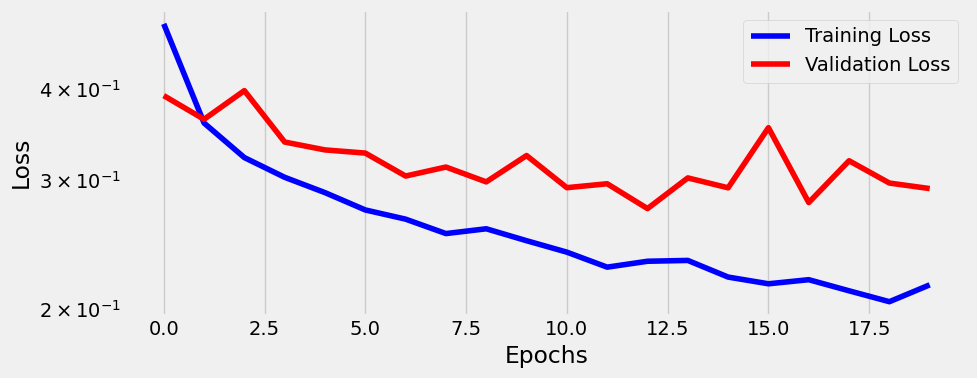

In [98]:
fig = sbs_emb.plot_losses()

In [99]:
StepByStep.loader_apply(test_loader, sbs_emb.correct)

tensor([[402, 439],
        [284, 332]])

## Model II - GloVe + Transformer

An instance of a transformer encoder, a layer of pre-trained embeddings and the desired number of outputs.

forward takes minibatches of tokenized sentences, preprocess them, encodes them and output the logits.

In [100]:
class TransfClassifier(nn.Module):
    def __init__(self, embedding_layer, encoder, n_outputs):
        super().__init__()
        self.d_model = encoder.d_model
        self.n_outputs = n_outputs
        self.encoder = encoder
        self.mlp = nn.Linear(self.d_model, n_outputs)

        self.embed = embedding_layer
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.d_model))

    def preprocess(self, X):
        # N, L -> N, L, D
        src = self.embed(X)
        # Special classifier token
        # 1, 1, D -> N, 1, D
        cls_tokens = self.cls_token.expand(X.size(0), -1, -1)
        # Concatenates CLS tokens -> N, 1 + L, D
        src = torch.cat((cls_tokens, src), dim=1)
        return src

    def encode(self, source, source_mask=None):
        # Encoder generates "hidden states"
        states = self.encoder(source, source_mask)
        # Gets state from first token only: [CLS]
        cls_state = states[:, 0]  # N, 1, D
        return cls_state

    @staticmethod
    def source_mask(X):
        cls_mask = torch.ones(X.size(0), 1).type_as(X)
        pad_mask = torch.cat((cls_mask, X > 0), dim=1).bool()
        return pad_mask.unsqueeze(1)

    def forward(self, X):
        src = self.preprocess(X)
        # Featurizer
        cls_state = self.encode(src, self.source_mask(X))
        # Classifier
        out = self.mlp(cls_state) # N, 1, outputs
        return out

In [101]:
torch.manual_seed(33)
# Loads the pretrained GloVe embeddings into an embedding layer
torch_embeddings = nn.Embedding.from_pretrained(extended_embeddings)
# Creates a Transformer Encoder
layer = EncoderLayer(n_heads=2, d_model=torch_embeddings.embedding_dim, ff_units=128)
encoder = EncoderTransf(layer, n_layers=1)
# Uses both layers above to build our model
model = TransfClassifier(torch_embeddings, encoder, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [102]:
sbs_transf = StepByStep(model, loss_fn, optimizer)
sbs_transf.set_loaders(train_loader, test_loader)
sbs_transf.train(10)

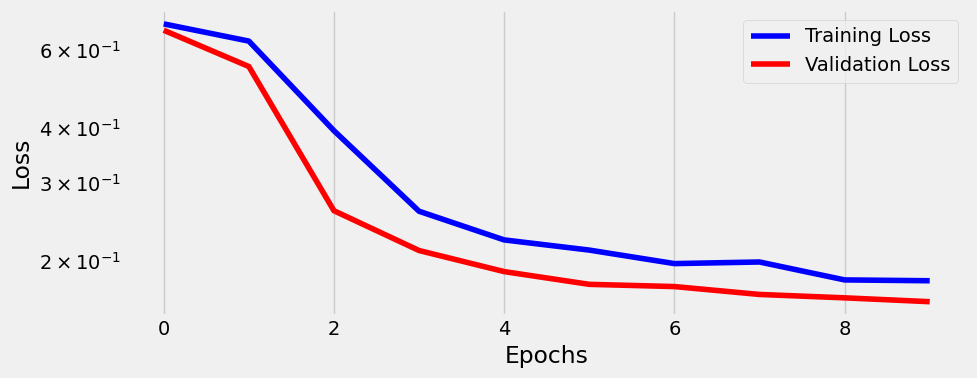

In [103]:
fig = sbs_transf.plot_losses()

In [104]:
StepByStep.loader_apply(test_loader, sbs_transf.correct)

tensor([[421, 439],
        [299, 332]])

### Visualizing Attention

In [105]:
sentences = ['The white rabbit and Alice ran away', 'The lion met Dorothy on the road']
inputs = glove_tokenizer(sentences, add_special_tokens=False, return_tensors='pt')['input_ids']
inputs = inputs.to(sbs_transf.device)
inputs

tensor([[    2,   300, 12427,     7,  7101,  1423,   422],
        [    2,  6659,   811, 11238,    15,     2,   588]], device='cuda:0')

In [106]:
sbs_transf.model.eval()
out = sbs_transf.model(inputs)
# our model outputs logits, so we turn them into probs
torch.sigmoid(out)

tensor([[0.9890],
        [0.0087]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [107]:
alphas = sbs_transf.model.encoder.layers[0].self_attn_heads.alphas
alphas[:, :, 0, :].squeeze()

tensor([[[3.3053e-01, 6.5329e-02, 1.9949e-01, 1.3869e-01, 9.0633e-02,
          1.1651e-01, 4.7055e-02, 1.1756e-02],
         [4.8211e-05, 3.8650e-03, 5.8547e-03, 1.1963e-01, 4.4671e-03,
          8.6292e-01, 1.2019e-03, 2.0168e-03]],

        [[1.0110e-01, 1.9982e-02, 1.3681e-01, 6.5325e-02, 5.5102e-01,
          1.1234e-02, 1.8335e-02, 9.6198e-02],
         [3.4067e-04, 2.7311e-02, 3.8560e-01, 3.0129e-02, 4.3987e-01,
          4.8765e-02, 3.2907e-02, 3.5071e-02]]], device='cuda:0')

/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])
/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])
/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])
/content/plots/chapter11.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', f'Head #{i}', ''])


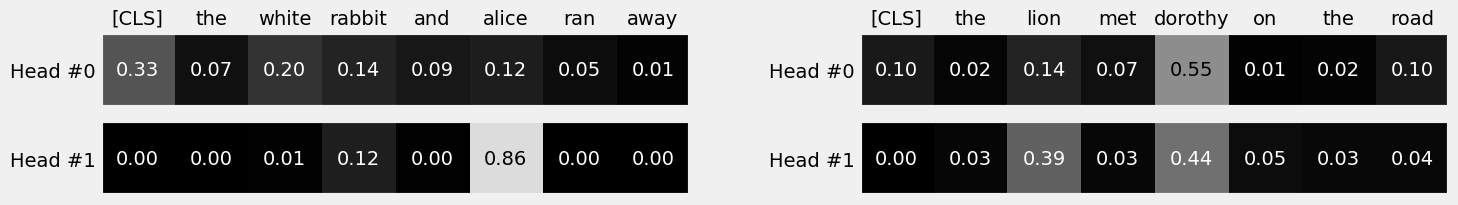

In [108]:
tokens = [['[CLS]'] + glove_tokenizer.tokenize(sent) for sent in sentences]
fig = plot_attention(tokens, alphas)

# Contextual Word Embeddings

## ELMo

Watch in these two sentences has a different meaning noun and verb. Probabily, the single word embedding is not enough... we need to consider the context, the sentence itself to represent the word.

These are called contextual word embeddings where we don't have a look-up table between every combination of word and context, but the embeddings are the outputs of a model :-)

ELMo takes into account also the context.

It is a two layer bidirectional LSTM encoder using 4096 dimensions for its cell states

The representations are char-based, so it can easily handle unkown words

Flair is a NLP (yet another) library built on top of pytorch that offers word embeddings and document embeddings for ELMo and BERT as well as GloVe.

In [109]:
watch1 = """
The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.
"""

watch2 = """
Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!
"""

sentences = [watch1, watch2]

In [110]:
from flair.data import Sentence

flair_sentences = [Sentence(s) for s in sentences]
flair_sentences[0]

Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear."

In [111]:
flair_sentences[0].get_token(32)

Token[31]: "watch"

In [112]:
flair_sentences[0].tokens[31]

Token[31]: "watch"

In [113]:
from flair.embeddings import FlairEmbeddings
flair_emb = FlairEmbeddings('news-forward')


In [114]:
flair_emb.embed(flair_sentences)


[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [115]:
token_watch1 = flair_sentences[0].tokens[31]
token_watch2 = flair_sentences[1].tokens[13]
token_watch1, token_watch2

(Token[31]: "watch", Token[13]: "watch")

In [116]:
token_watch1.embedding, token_watch2.embedding

(tensor([-0.0007, -0.0057,  0.0187,  ..., -0.0051, -0.0022,  0.0026],
        device='cuda:0'),
 tensor([-0.0011, -0.0037,  0.1031,  ..., -0.0079, -0.0044,  0.0002],
        device='cuda:0'))

In [117]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(token_watch1.embedding, token_watch2.embedding)

tensor(0.5003, device='cuda:0')

In [118]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    return torch.stack([token.embedding for token in sent.tokens]).float()

In [119]:
get_embeddings(flair_emb, watch1)


tensor([[-2.0933e-03,  5.0415e-04,  4.6944e-02,  ..., -4.4014e-04,
         -3.9301e-02,  1.0601e-02],
        [ 3.2224e-04,  1.4939e-03,  2.5947e-02,  ..., -9.2415e-04,
         -1.4211e-02,  3.0942e-03],
        [ 1.7407e-03, -1.8324e-04,  5.3375e-02,  ...,  4.5165e-04,
          5.4484e-02,  9.7125e-03],
        ...,
        [ 2.2250e-03,  2.2138e-04,  4.4385e-02,  ..., -3.9766e-03,
         -7.9449e-04,  2.2444e-02],
        [-2.2455e-03,  9.7197e-04,  3.4624e-02,  ..., -7.1559e-05,
          1.2647e-02,  1.3210e-02],
        [ 1.0997e-03,  8.4726e-05,  1.5534e-01,  ..., -1.5737e-04,
          9.5801e-04,  5.3785e-03]], device='cuda:0')

## GloVe

In [120]:
from flair.embeddings import WordEmbeddings
glove_embedding = WordEmbeddings('glove')

In [121]:
new_flair_sentences = [Sentence(s) for s in sentences]
glove_embedding.embed(new_flair_sentences)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [122]:
torch.all(new_flair_sentences[0].tokens[31].embedding == new_flair_sentences[1].tokens[13].embedding)

tensor(True, device='cuda:0')

## BERT

In [123]:
from flair.embeddings import TransformerWordEmbeddings
bert_flair = TransformerWordEmbeddings('bert-base-uncased', layers='-1')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [124]:
embed1 = get_embeddings(bert_flair, watch1)
embed2 = get_embeddings(bert_flair, watch2)
embed2

tensor([[ 0.6554, -0.3799, -0.2842,  ...,  0.0601,  0.8865,  0.4760],
        [-0.1459, -0.0204, -0.0615,  ..., -0.0257,  0.5052,  0.3324],
        [-0.0436, -0.0400, -0.0135,  ...,  0.3920,  0.5231,  0.9067],
        ...,
        [-0.2582,  0.6933,  0.2688,  ..., -0.0325,  0.0772,  0.2187],
        [-0.1868,  0.6398, -0.8127,  ..., -0.5957,  0.2793,  0.1880],
        [-0.1021,  0.5222, -0.7142,  ...,  0.3644,  0.0600, -0.1419]],
       device='cuda:0')

In [125]:
bert_watch1 = embed1[31]
bert_watch2 = embed2[13]
bert_watch1, bert_watch2

(tensor([ 8.5760e-01,  3.5888e-01, -3.7825e-01, -8.3564e-01,  1.3528e+00,
          1.0204e-01, -8.2618e-01,  3.1570e-01,  3.1091e-01, -4.2653e-01,
          1.6632e-01,  7.2440e-02, -1.0276e+00,  4.4680e-01, -1.4549e-01,
          1.8315e-01,  3.7484e-01, -4.0245e-01, -1.4190e-01, -5.1596e-01,
          1.1984e+00,  6.8202e-01,  1.1028e+00, -4.3956e-02,  1.6932e-02,
          7.4420e-01, -1.0604e-01,  3.8719e-01,  7.3662e-02,  2.2424e-01,
         -5.0282e-02,  1.9586e-01,  1.0773e+00,  1.0341e+00,  4.4217e-01,
         -6.5567e-01, -5.6308e-01, -1.1827e-01,  1.2862e-01,  4.6581e-01,
         -7.1305e-01, -1.5682e-01, -1.3552e-01,  4.5852e-02,  8.2852e-03,
          5.2762e-01,  1.6906e+00,  5.5388e-01, -7.3777e-02,  5.1504e-01,
         -2.0619e-01, -2.9503e-03,  2.5389e-01, -1.5379e-01,  8.4900e-01,
          6.5440e-01, -3.2925e-01, -1.1198e+00,  2.4251e-01,  1.5586e-01,
          5.7514e-01,  8.5832e-02,  3.3306e-01, -3.9344e-01, -4.1766e-01,
          1.0790e+00,  1.1719e-02,  7.

In [126]:
similarity = nn.CosineSimilarity(dim=0, eps=1e-6)
similarity(bert_watch1, bert_watch2)

tensor(0.3504, device='cuda:0')

## Document Embeddings

In [127]:
documents = [Sentence(watch1), Sentence(watch2)]

In [128]:
from flair.embeddings import TransformerDocumentEmbeddings
bert_doc = TransformerDocumentEmbeddings('bert-base-uncased')
bert_doc.embed(documents)

[Sentence[58]: " The Hatter was the first to break the silence. `What day of the month is it?' he said, turning to Alice:  he had taken his watch out of his pocket, and was looking at it uneasily, shaking it every now and then, and holding it to his ear.",
 Sentence[48]: " Alice thought this a very curious thing, and she went nearer to watch them, and just as she came up to them she heard one of them say, `Look out now, Five!  Don't go splashing paint over me like that!"]

In [129]:
documents[0].embedding

tensor([-6.4245e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4678e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6129e-01,  1.2309e-01, -1.2047e-02,
        -5.0255e-01,  4.2645e-01, -3.7184e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8483e-02, -4.7287e-01, -7.4431e-02,
         2.3990e-01, -8.3232e-02,  1.7974e-01,  4.8939e-01,  9.3026e-03,
        -4.2722e-01,  2.6337e-01, -1.3217e-01, -1.3950e-01, -1.1859e-01,
         4.5835e-02, -3.9031e+00, -1.0726e-01,  5.1103e-02, -9.9710e-02,
         1.5913e-01, -9.5331e-02,  2.1513e-01,  4.7707e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9427e-02,  3.3968e-01,
         4.1062e-01, -2.1051e-02,  2.7801e-02,  2.8

In [130]:
documents[0].tokens[31].embedding

tensor([], device='cuda:0')

In [131]:
def get_embeddings(embeddings, sentence):
    sent = Sentence(sentence)
    embeddings.embed(sent)
    if len(sent.embedding):
        return sent.embedding.float()
    else:
        return torch.stack([token.embedding for token in sent.tokens]).float()

In [132]:
get_embeddings(bert_doc, watch1)

tensor([-6.4245e-02,  3.5365e-01, -2.4962e-01, -5.3912e-01, -1.9917e-01,
        -2.7712e-01,  1.6942e-01,  1.0867e-01, -4.0799e-01, -1.4945e-01,
         4.4679e-02, -1.9687e-01, -3.0574e-01,  9.6215e-02,  2.8053e-01,
         9.0462e-01, -3.0250e-01,  1.7854e-01, -1.6856e-01, -1.7227e-01,
        -1.8270e-01,  4.5121e-01,  3.6128e-01,  1.2309e-01, -1.2047e-02,
        -5.0255e-01,  4.2645e-01, -3.7184e-02, -1.7052e-01, -4.8920e-02,
         1.0503e-01,  3.3456e-01, -3.8483e-02, -4.7287e-01, -7.4431e-02,
         2.3990e-01, -8.3232e-02,  1.7974e-01,  4.8939e-01,  9.3027e-03,
        -4.2722e-01,  2.6337e-01, -1.3217e-01, -1.3950e-01, -1.1859e-01,
         4.5834e-02, -3.9031e+00, -1.0726e-01,  5.1103e-02, -9.9710e-02,
         1.5913e-01, -9.5331e-02,  2.1513e-01,  4.7707e-01,  2.1226e-01,
         4.3450e-01, -4.5154e-01,  1.8344e-01, -1.0171e-01, -3.6373e-01,
         8.9560e-01,  3.5931e-01, -2.8519e-01,  2.9427e-02,  3.3968e-01,
         4.1062e-01, -2.1051e-02,  2.7801e-02,  2.8

## Model III - Preprocessing Embeddings

We need to use the get_embeddings for every sentence, therefore we can use the map function of the HF dataset, then we need the embeddings to be PyTorch Tensors

### Data Preparation

In [133]:
train_dataset_doc = train_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})
test_dataset_doc = test_dataset.map(lambda row: {'embeddings': get_embeddings(bert_doc, row['sentence'])})

Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

In [134]:
train_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])
test_dataset_doc.set_format(type='torch', columns=['embeddings', 'labels'])

In [135]:
train_dataset_doc['embeddings']

tensor([[-0.1071,  0.1749, -0.3736,  ...,  0.1728,  0.4771,  0.1880],
        [ 0.1943,  0.2982, -0.2114,  ...,  0.2389,  0.6941,  0.3247],
        [ 0.0146,  0.6776,  0.1247,  ...,  0.0772,  0.4604,  0.7915],
        ...,
        [-0.6176, -0.2704, -0.3849,  ...,  0.1850,  0.0498,  0.7585],
        [-0.0017,  0.2743, -0.3690,  ...,  0.3302,  0.7468,  0.1692],
        [ 0.1021, -0.0921,  0.1216,  ...,  0.1355,  0.3016,  0.3672]])

In [136]:
train_dataset_doc = TensorDataset(train_dataset_doc['embeddings'].float(),
                                  train_dataset_doc['labels'].view(-1, 1).float())
generator = torch.Generator()
train_loader = DataLoader(train_dataset_doc, batch_size=32, shuffle=True, generator=generator)

test_dataset_doc = TensorDataset(test_dataset_doc['embeddings'].float(),
                                 test_dataset_doc['labels'].view(-1, 1).float())
test_loader = DataLoader(test_dataset_doc, batch_size=32, shuffle=True)

### Model Configuration & Training

In [137]:
torch.manual_seed(41)
model = nn.Sequential(
    # Classifier
    nn.Linear(bert_doc.embedding_length, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [138]:
sbs_doc_emb = StepByStep(model, loss_fn, optimizer)
sbs_doc_emb.set_loaders(train_loader, test_loader)
sbs_doc_emb.train(20)

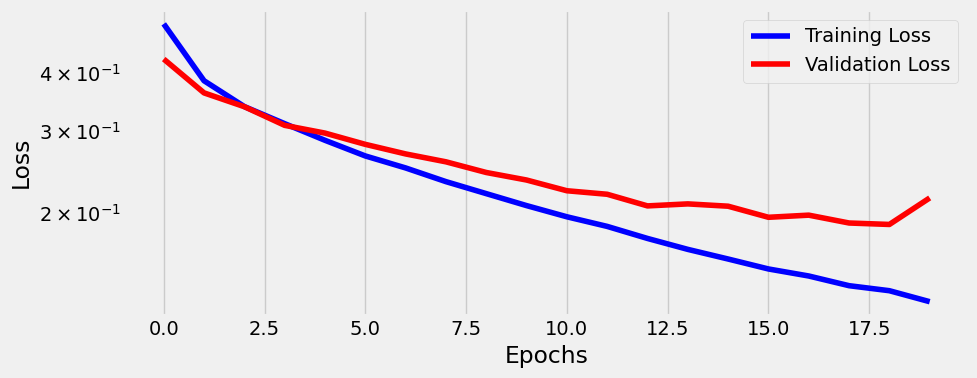

In [139]:
fig = sbs_doc_emb.plot_losses()

In [140]:
StepByStep.loader_apply(test_loader, sbs_doc_emb.correct)

tensor([[422, 439],
        [312, 332]])

# BERT

**B**idirectional **E**ncoder **R**epresentation from **T**ransformers $→$ **BERT**

It is a model based on a **transformer encoder**.

It was introduced in a paper titled: *BERT: Pre-training of Bidirectional Transformers for Language Understanding* (2019)

Some number to give you an idea:
Trained on huge corpora: BookCorpus, 800M of words, 11.038 unpublished books and English Wikipedia with 2.5B of words

12 layers, 12 attention heads, 768 hidden dimensions, with a total of 110 Milion Parameters.

What does this mean? That we don't have -- as personal users -- the computational resources to train such a kind of models.

HuggingFace is at our disposal and there are many different version of BERT available.

What do we want to do now?

USE A PRE-TRAINED VERSION OF BERT, FINE-TUNING IT FOR OUR PURPOSES AND EVALUATE ON OUR SENTENCE CLASSIFIER

In [141]:
'''
if you want to try different models without having to import their
corresponding classes, you can use HuggingFace's AutoModel

It infers the corret model class based on the name of the model you are loading
'''
from transformers import AutoModel
auto_model = AutoModel.from_pretrained('bert-base-uncased')
print(auto_model.__class__)



<class 'transformers.models.bert.modeling_bert.BertModel'>


In [142]:
'''
Or you can import the class model
'''

from transformers import BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [143]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.38.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

We are able to recognize some of these parameters, right?
hidden_size, num_attention_heads, num_hidden_layers...

Some of them will be explained in few minutes.

But first of all, our model needs to receive inputs and these inputs need to be **TOKENIZED**


## Tokenization

We can consider the tokenization as a pre-processing step, and since we are going to use a pre-trained BERT model, we need to use the same tokenizer that was used during the pre-training.

So, in HF each pre-trained model has its own pre-trained tokenizer as well.

Let's create our BERT tokenizer...

In [144]:
from transformers import BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
len(bert_tokenizer.vocab)

30522

Only ```30522`` tokens...
But in reality these are not exactly words but they may also be **word pieces**.


Before, for words not belonging to our vocabulary we used the special token ```[UNK]```.
This approach gets some information loss, all the unknown words are replaced with the same token.

The approach defined here is a litlle bit different.
We disassemble an unknown word into its components, and for instance the word ```inexplicably``` can be disassembled into five word pieces:

```inexplicably``` $→$ ```in + ##ex + ##pl + ##ica + ##bly```  

Every word pieces is prefixed with ```##``` to indicate that is doesn't stand on its own as a word.

Therefore, an unknown word becomes a concatenation of **word-pieces**

In [145]:
sentence1 = 'Alice is inexplicably following the white rabbit'
sentence2 = 'Follow the white rabbit, Neo'
tokens = bert_tokenizer(sentence1, sentence2, return_tensors='pt')
tokens

{'input_ids': tensor([[  101,  5650,  2003,  1999, 10288, 24759,  5555,  6321,  2206,  1996,
          2317, 10442,   102,  3582,  1996,  2317, 10442,  1010,  9253,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

- input_ids contains the token id,
- token_type_ids contains the sentence index
- the attention mask is self explanatory.

In [146]:
'''
We take the ids (input_ids)
and we convert them to the corresponding word pieces (tokens)
'''

print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]', 'follow', 'the', 'white', 'rabbit', ',', 'neo', '[SEP]']


- [CLS] at the start, the classifier token
- [SEP] between the two sentences and at the end
- inexplicably got disassemled into word pieces

In [147]:
'''
As for the model you can use the AutoTokenizer
to try different tokenizers without importing their classes
'''

from transformers import AutoTokenizer
auto_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
print(auto_tokenizer.__class__)

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


## Input Embeddings

Once the sentences are tokenized, we can use their tokens' IDs to look up the corresponding embeddings, as usual.

1. BERT is a transformer encoder, and it needs positional information, and BERT uses **position embeddings**
  a. position encoding used before had fixed values for each position, the **position embeddings** are learned by the model, as any other embedding layer. The number of entries is defined by the maximum length of the sequence (see parameters above).

2. BERT adds a third embedding: segment embedding, which is a position embedding at the sentence level

**Original Design of BERT**

- BERT was designed to handle tasks involving one sentence or two sentences.
- For single-sentence tasks (e.g., sentiment analysis), the input is just one sentence.
- For tasks requiring two sentences (e.g., next sentence prediction or sentence-pair classification), the input consists of two segments: Sentence A [SEP] Sentence B.


![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_input_embed.png?raw=1)

In [148]:
input_embeddings = bert_model.embeddings
input_embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [149]:
token_embeddings = input_embeddings.word_embeddings
token_embeddings

Embedding(30522, 768, padding_idx=0)

30522 entries, and 768 hidden dimensions

In [150]:
input_token_emb = token_embeddings(tokens['input_ids'])
input_token_emb,input_token_emb.shape

(tensor([[[ 1.3630e-02, -2.6490e-02, -2.3503e-02,  ...,  8.6805e-03,
            7.1340e-03,  1.5147e-02],
          [-6.9710e-02, -8.8202e-02,  5.0619e-03,  ...,  1.4105e-02,
            2.1815e-02, -1.3769e-02],
          [-3.6044e-02, -2.4606e-02, -2.5735e-02,  ...,  3.3691e-03,
           -1.8300e-03,  2.6855e-02],
          ...,
          [ 5.2089e-05, -1.0468e-02, -9.9103e-03,  ...,  1.4558e-02,
            1.3217e-02,  2.2406e-02],
          [-3.5037e-02, -7.2933e-02, -3.6124e-02,  ..., -5.7723e-02,
           -5.5074e-03,  7.2688e-03],
          [-1.4521e-02, -9.9615e-03,  6.0263e-03,  ..., -2.5035e-02,
            4.6379e-03, -1.5378e-03]]], grad_fn=<EmbeddingBackward0>),
 torch.Size([1, 20, 768]))

In [151]:
position_embeddings = input_embeddings.position_embeddings
position_embeddings

Embedding(512, 768)

In [152]:
position_ids = torch.arange(512).expand((1, -1))
position_ids

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

In [153]:
seq_length = tokens['input_ids'].size(1)
input_pos_emb = position_embeddings(position_ids[:, :seq_length])
input_pos_emb,input_pos_emb.shape

(tensor([[[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
            6.8312e-04,  1.5441e-02],
          [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
            2.9753e-02, -5.3247e-03],
          [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
            1.8741e-02, -7.3140e-03],
          ...,
          [-9.2809e-03,  8.3268e-03, -4.1643e-03,  ...,  3.4903e-02,
           -1.8319e-02, -2.9017e-03],
          [-8.5999e-03,  3.2205e-04, -2.1249e-03,  ...,  2.7744e-02,
           -7.2760e-03, -2.0280e-03],
          [-3.4622e-04, -8.3709e-04, -2.2228e-02,  ...,  2.3493e-02,
           -4.5198e-04, -5.7741e-04]]], grad_fn=<EmbeddingBackward0>),
 torch.Size([1, 20, 768]))

In [154]:
segment_embeddings = input_embeddings.token_type_embeddings
segment_embeddings

Embedding(2, 768)

In [155]:
input_seg_emb = segment_embeddings(tokens['token_type_ids'])
input_seg_emb

tensor([[[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
         ...,
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112],
         [ 0.0011, -0.0030, -0.0032,  ...,  0.0047, -0.0052, -0.0112]]],
       grad_fn=<EmbeddingBackward0>)

BERT adds all three embeddings, then layer normalize and dropout, but these are the inputs that BERT uses

In [156]:
input_emb = input_token_emb + input_pos_emb + input_seg_emb
input_emb

tensor([[[ 0.0316, -0.0411, -0.0564,  ...,  0.0021,  0.0044,  0.0219],
         [-0.0615, -0.0750, -0.0107,  ...,  0.0364,  0.0482, -0.0277],
         [-0.0469, -0.0156, -0.0336,  ...,  0.0117,  0.0135,  0.0109],
         ...,
         [-0.0081, -0.0051, -0.0172,  ...,  0.0542, -0.0103,  0.0083],
         [-0.0425, -0.0756, -0.0414,  ..., -0.0252, -0.0180, -0.0060],
         [-0.0138, -0.0138, -0.0194,  ...,  0.0032, -0.0011, -0.0133]]],
       grad_fn=<AddBackward0>)

## Pretraining Tasks

BERT is a autoencoding model because it is a trasfomer encoder and because it was trained to reconstruct sentences from corrupted inputs.

This type of Language models are called masked language models (MLM) pre-training task.

It tries to predict a masked word/token that is inside a sentence, filling the blanks as the continous bag-of-words (CBoW) does.

There are strategies to select which token has to be masked, the target of our encoder is the original sentence.

In particular, BERT computes the logits only for the randomly masked inputs, the others are not used to compute the loss.

### Masked Language Model (MLM)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_mlm.png?raw=1)

In [157]:
sentence = 'Alice is inexplicably following the white rabbit'
tokens = bert_tokenizer(sentence)
tokens['input_ids']

[101, 5650, 2003, 1999, 10288, 24759, 5555, 6321, 2206, 1996, 2317, 10442, 102]

In [158]:
from transformers import DataCollatorForLanguageModeling
torch.manual_seed(41)
data_collator = DataCollatorForLanguageModeling(tokenizer=bert_tokenizer, mlm_probability=0.15)
mlm_tokens = data_collator([tokens])
mlm_tokens

{'input_ids': tensor([[  101,  5650,  2003,  1999, 10288, 24759,   103,  6321,  2206,  1996,
          2317, 10442,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[-100, -100, -100, -100, -100, -100, 5555, -100, -100, -100, -100, -100,
         -100]])}

In [159]:
print(bert_tokenizer.convert_ids_to_tokens(tokens['input_ids']))
print(bert_tokenizer.convert_ids_to_tokens(mlm_tokens['input_ids'][0]))

['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '##ica', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']
['[CLS]', 'alice', 'is', 'in', '##ex', '##pl', '[MASK]', '##bly', 'following', 'the', 'white', 'rabbit', '[SEP]']


### Next Sentence Prediction (NSP)

Another pre-training task is the Next Sentence Prediction (NSP) task.
BERT was trained to predict if a second sentence is actually the next sentence in the original text or not.

In this way, the model learns the relationships between the sencences.

This task takes the special classifier token [CLS] (its final hidden states) as features for a classifier.


![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_nsp.png?raw=1)

In [160]:
bert_model.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [161]:
sentence1 = 'alice follows the white rabbit'
sentence2 = 'follow the white rabbit neo'
bert_tokenizer(sentence1, sentence2, return_tensors='pt')

{'input_ids': tensor([[  101,  5650,  4076,  1996,  2317, 10442,   102,  3582,  1996,  2317,
         10442,  9253,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## Outputs

In [162]:
sentence = 'And, so far as they knew, they were quite right' #train_dataset[100]['sentence']
sentence

'And, so far as they knew, they were quite right'

In [163]:
tokens = bert_tokenizer(sentence,
                        padding='max_length',
                        max_length=30,
                        truncation=True,
                        return_tensors="pt")
tokens

{'input_ids': tensor([[ 101, 1998, 1010, 2061, 2521, 2004, 2027, 2354, 1010, 2027, 2020, 3243,
         2157,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]])}

In [164]:
bert_model.eval()
out = bert_model(input_ids=tokens['input_ids'],
                 attention_mask=tokens['attention_mask'],
                 output_attentions=True,
                 output_hidden_states=True,
                 return_dict=True)

print()
out.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

-```last_hidden_state``` is returned by default and is the most importan output of the all: it contains the final hidden states for each and every token in the input, this can be seen as **contextual word embeddings**

  - [CLS], [SEP], and [PAD] are also included

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/bert_embeddings.png?raw=1)

In [165]:
last_hidden_batch = out['last_hidden_state']
last_hidden_sentence = last_hidden_batch[0]
# Removes hidden states for [PAD] tokens using the mask
mask = tokens['attention_mask'].squeeze().bool()
embeddings = last_hidden_sentence[mask]
# Removes embeddings for the first [CLS] and last [SEP] tokens
embeddings[1:-1]

tensor([[-0.0207,  0.7596, -0.3298,  ..., -0.0624,  0.5881, -0.3320],
        [-0.2141,  0.9708,  0.3524,  ..., -0.7776,  0.0939, -0.7059],
        [-0.1622,  0.5184,  0.2489,  ..., -0.6274, -0.3363,  0.3238],
        ...,
        [ 0.3006,  0.4791, -0.4585,  ..., -0.3678,  0.3518, -0.4639],
        [ 0.0714,  0.5561,  0.3115,  ..., -0.5760, -0.5615, -0.8796],
        [-0.3458,  0.0045,  0.2338,  ...,  0.5585,  0.5742, -0.8070]],
       grad_fn=<SliceBackward0>)

In [166]:
get_embeddings(bert_flair, sentence)

tensor([[-0.0207,  0.7596, -0.3298,  ..., -0.0624,  0.5881, -0.3320],
        [-0.2141,  0.9708,  0.3524,  ..., -0.7776,  0.0939, -0.7059],
        [-0.1622,  0.5184,  0.2489,  ..., -0.6274, -0.3363,  0.3238],
        ...,
        [ 0.3006,  0.4791, -0.4585,  ..., -0.3678,  0.3518, -0.4639],
        [ 0.0714,  0.5561,  0.3115,  ..., -0.5760, -0.5615, -0.8796],
        [-0.3458,  0.0045,  0.2338,  ...,  0.5585,  0.5742, -0.8070]],
       device='cuda:0')

- ```hidden_states``` returns hidden states for every layer in BERT encoder architecture, including the last one, and the input embedding as well.

Therefore 12 +1 (the input embeddings)

In [167]:
print(len(out['hidden_states']))
print(out['hidden_states'][0].shape)

13
torch.Size([1, 30, 768])


In [168]:
(out['hidden_states'][0] == bert_model.embeddings(tokens['input_ids'])).all()

tensor(True)

In [169]:
(out['hidden_states'][-1] == out['last_hidden_state']).all()

tensor(True)

- ```pooler_output``` is returned by default, it's the output of the pooler given the last hidden state as its input

In [170]:
(out['pooler_output'] == bert_model.pooler(out['last_hidden_state'])).all()

tensor(True)

- ```attentions``` return the self-attention scores for each attention head in each layer of BERT's encoder:

In [171]:
print(len(out['attentions']))
print(out['attentions'][0].shape)

12
torch.Size([1, 12, 30, 30])


In [172]:
print(type(out['attentions']))

<class 'tuple'>


12 elements, one for each layer, each element has a tensor containing the scores for the sentences in the mini-batch (only one in our case). Those scores include each 12 self-attention heads, each head indicating how mcuh attention each of the 30 tokens is paying to all 30 tokens.

## Model IV - Classifying using BERT

In [173]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, ff_units, n_outputs, dropout=0.3):
        super().__init__()
        self.d_model = bert_model.config.dim
        self.n_outputs = n_outputs
        self.encoder = bert_model
        self.mlp = nn.Sequential(
            nn.Linear(self.d_model, ff_units),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_units, n_outputs)
        )

    def encode(self, source, source_mask=None):
        states = self.encoder(input_ids=source,
                              attention_mask=source_mask)[0]
        cls_state = states[:, 0]
        return cls_state

    def forward(self, X):
        source_mask = (X > 0)
        # Featurizer
        cls_state = self.encode(X, source_mask)
        # Classifier
        out = self.mlp(cls_state)
        return out

our model takes
- an instance of a pretrained BERT model.
- the desidered number of outputs (logits) corresponding to the number of classes
- the ```forward()``` takes mini-batch of token-ids, encodes them using BERT and outputs logits

### Data Preparation

In [174]:
def tokenize_dataset(hf_dataset, sentence_field, label_field, tokenizer, **kwargs):
    sentences = hf_dataset[sentence_field]
    token_ids = tokenizer(sentences, return_tensors='pt', **kwargs)['input_ids']
    labels = torch.as_tensor(hf_dataset[label_field])
    dataset = TensorDataset(token_ids, labels)
    return dataset

In [175]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer_kwargs = dict(truncation=True, padding=True, max_length=30, add_special_tokens=True)

In [176]:
train_dataset_float = train_dataset.map(lambda row: {'labels': [float(row['labels'])]})
test_dataset_float = test_dataset.map(lambda row: {'labels': [float(row['labels'])]})

train_tensor_dataset = tokenize_dataset(train_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)
test_tensor_dataset = tokenize_dataset(test_dataset_float, 'sentence', 'labels', auto_tokenizer, **tokenizer_kwargs)

generator = torch.Generator()
train_loader = DataLoader(train_tensor_dataset, batch_size=4, shuffle=True, generator=generator)
test_loader = DataLoader(test_tensor_dataset, batch_size=8)

Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

### Model Configuration & Training

In [177]:
torch.manual_seed(41)
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
model = BERTClassifier(bert_model, 128, n_outputs=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [178]:
sbs_bert = StepByStep(model, loss_fn, optimizer)
sbs_bert.set_loaders(train_loader, test_loader)
sbs_bert.train(1)

In [179]:
sbs_bert.count_parameters()

66461441

In [180]:
StepByStep.loader_apply(test_loader, sbs_bert.correct)

tensor([[426, 439],
        [320, 332]])

# Fine-Tuning with HuggingFace

As we said before, there is a BERT model for every task, and we need just to fine-tune it.

HF makes at our disposal a **trainer** to do most of the fine-tuning work.

- Pre-training tasks:
  - Masked language mode (```BertForMaskedLM```)
  - Next sentence prediction (```BertForNextSentencePrediction```)
- Typical tasks:
  - Sequence classification (```BertForSequenceClassification```)
  - Token classification (```BertForTokenClassification```)
  - Question answering (```BertForQuestionAnswering```)
- Others:
 - Multiple choice (```BertForMultipleChoice```)

 In our case, we want to use ```DistilBERT``` for sequence classification.


## Sequence Classification (or Regression)

In [181]:
from transformers import DistilBertForSequenceClassification
torch.manual_seed(42)
bert_cls = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

In [182]:
from transformers import AutoModelForSequenceClassification
auto_cls = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
print(auto_cls.__class__)

<class 'transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification'>


What we need to do is to add a single linear layer (classifier) on top of the pooled output from the underlying model to produce the logits.

We have the model, we prepare the dataset...

We need to tokenize our HF's datasets, and we do it one row at the time creating a new column to contain the tokenized version of the sentence.

## Tokenized Dataset

In [183]:
auto_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize(row):
    return auto_tokenizer(row['sentence'],
                          truncation=True,
                          padding='max_length',
                          max_length=30)

In [184]:
tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3081 [00:00<?, ? examples/s]

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

In [185]:
print(tokenized_train_dataset[0])

{'sentence': 'The Winkies were sorry to have them go, and they had grown so fond of the Tin Woodman that they begged him to stay and rule over them and the Yellow Land of the West.', 'source': 'wizoz10-1740.txt', 'labels': 0, 'input_ids': [101, 1996, 16837, 3111, 2020, 3374, 2000, 2031, 2068, 2175, 1010, 1998, 2027, 2018, 4961, 2061, 13545, 1997, 1996, 9543, 3536, 2386, 2008, 2027, 12999, 2032, 2000, 2994, 1998, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [186]:
'''
we select only the need columns and return them as tensors
'''

tokenized_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [187]:
tokenized_train_dataset[0]

{'labels': tensor(0),
 'input_ids': tensor([  101,  1996, 16837,  3111,  2020,  3374,  2000,  2031,  2068,  2175,
          1010,  1998,  2027,  2018,  4961,  2061, 13545,  1997,  1996,  9543,
          3536,  2386,  2008,  2027, 12999,  2032,  2000,  2994,  1998,   102]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1])}

## Trainer

In [188]:
from transformers import Trainer
trainer = Trainer(model=bert_cls, train_dataset=tokenized_train_dataset)

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [189]:
trainer.args

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=True,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'min_num_params': 0, 'xla': False, 'xla_fsdp_v2': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsd

In [191]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='./output', # Where to save the output files
    run_name="bert_experiment",  # Set a unique name for this run
    logging_dir="./logs",  # Directory for logging
    report_to=["none"],
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=300,
    logging_steps=300,
    gradient_accumulation_steps=8,
)

Check the batch size, it is only one, but we keep accumulating the gradients for 8 steps, it is a way to simulate 8 size batches.

In [192]:
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

We can specify a class to compute the desired metrics and pass it to the Trainer instance

In [193]:
trainer = Trainer(model=bert_cls,
                  args=training_args,
                  train_dataset=tokenized_train_dataset,
                  eval_dataset=tokenized_test_dataset,
                  compute_metrics=compute_metrics)

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [194]:
trainer.train()

{'loss': 0.1862, 'grad_norm': 0.17630140483379364, 'learning_rate': 1.103896103896104e-05, 'epoch': 0.78}
{'train_runtime': 77.4024, 'train_samples_per_second': 39.805, 'train_steps_per_second': 4.974, 'train_loss': 0.17753081631350828, 'epoch': 1.0}


TrainOutput(global_step=385, training_loss=0.17753081631350828, metrics={'train_runtime': 77.4024, 'train_samples_per_second': 39.805, 'train_steps_per_second': 4.974, 'train_loss': 0.17753081631350828, 'epoch': 1.0})

In [195]:
trainer.evaluate()

{'eval_loss': 0.12620297074317932, 'eval_accuracy': 0.9662775616083009, 'eval_runtime': 0.8618, 'eval_samples_per_second': 894.627, 'eval_steps_per_second': 112.554, 'epoch': 1.0}


{'eval_loss': 0.12620297074317932,
 'eval_accuracy': 0.9662775616083009,
 'eval_runtime': 0.8618,
 'eval_samples_per_second': 894.627,
 'eval_steps_per_second': 112.554,
 'epoch': 1.0}

We can save it, and use later.

In [196]:
trainer.save_model('bert_alice_vs_wizard')
os.listdir('bert_alice_vs_wizard')

['training_args.bin', 'config.json', 'model.safetensors']

In [197]:
loaded_model = AutoModelForSequenceClassification.from_pretrained('bert_alice_vs_wizard')
loaded_model.device

device(type='cpu')

In [198]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model.to(device)
loaded_model.device

device(type='cuda', index=0)

## Predictions

If you remember last time, we started with a peculiar sentence.
Now we are able to classify it (also before, you can try).

We tokenize it, we send to the right device and then we evaluate

In [199]:
sentence = 'Down the yellow brick rabbit hole'
tokens = auto_tokenizer(sentence, return_tensors='pt')
tokens

{'input_ids': tensor([[  101,  2091,  1996,  3756,  5318, 10442,  4920,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [200]:
print(type(tokens))
tokens.to(loaded_model.device)

<class 'transformers.tokenization_utils_base.BatchEncoding'>


{'input_ids': tensor([[  101,  2091,  1996,  3756,  5318, 10442,  4920,   102]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [201]:
loaded_model.eval()
logits = loaded_model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
logits

SequenceClassifierOutput(loss=None, logits=tensor([[-1.2816,  1.4760]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [202]:
logits.logits.argmax(dim=1)

tensor([1], device='cuda:0')

## Pipeline

We can make it more efficient using pipelines

There are many pipelines, one for each task:
- ```TextClassificationPipeline```
- ```TextGenerationPipeline```

Every pipeline takes at least two argument:
- a model
- a tokenizer

Now, we can make predictions using the **original sentences**

In [203]:
from transformers import TextClassificationPipeline
device_index = loaded_model.device.index if loaded_model.device.type != 'cpu' else -1
classifier = TextClassificationPipeline(model=loaded_model,
                                        tokenizer=auto_tokenizer,
                                        device=device_index)

In [204]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

[{'label': 'LABEL_1', 'score': 0.9403402805328369},
 {'label': 'LABEL_1', 'score': 0.9983327984809875}]

In [205]:
loaded_model.config.id2label = {0: 'Wizard', 1: 'Alice'}

In [206]:
classifier(['Down the Yellow Brick Rabbit Hole', 'Alice rules!'])

[{'label': 'Alice', 'score': 0.9403402805328369},
 {'label': 'Alice', 'score': 0.9983327984809875}]

## More Pipelines

It is possible to use pre-trained pipeline for **typical tasks** like sentiment analysis, without any fine-tuning.

*check the pipeline documentation on HuggingFace

In [207]:
from transformers import pipeline
sentiment = pipeline('sentiment-analysis')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [208]:
sentence = train_dataset[0]['sentence']
print(sentence)
print(sentiment(sentence))

The Winkies were sorry to have them go, and they had grown so fond of the Tin Woodman that they begged him to stay and rule over them and the Yellow Land of the West.
[{'label': 'POSITIVE', 'score': 0.9428057074546814}]


In [209]:
from transformers.pipelines import SUPPORTED_TASKS
# UPDATED
###########################################################
# sentiment-analysis was replaced by text-classification
# in the dictionary of supported tasks
# SUPPORTED_TASKS['sentiment-analysis']
SUPPORTED_TASKS['text-classification']
###########################################################

{'impl': transformers.pipelines.text_classification.TextClassificationPipeline,
 'tf': (transformers.models.auto.modeling_tf_auto.TFAutoModelForSequenceClassification,),
 'pt': (transformers.models.auto.modeling_auto.AutoModelForSequenceClassification,),
 'default': {'model': {'pt': ('distilbert/distilbert-base-uncased-finetuned-sst-2-english',
    'af0f99b'),
   'tf': ('distilbert/distilbert-base-uncased-finetuned-sst-2-english',
    'af0f99b')}},
 'type': 'text'}

In [210]:
SUPPORTED_TASKS

{'audio-classification': {'impl': transformers.pipelines.audio_classification.AudioClassificationPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForAudioClassification,),
  'default': {'model': {'pt': ('superb/wav2vec2-base-superb-ks', '372e048')}},
  'type': 'audio'},
 'automatic-speech-recognition': {'impl': transformers.pipelines.automatic_speech_recognition.AutomaticSpeechRecognitionPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForCTC,
   transformers.models.auto.modeling_auto.AutoModelForSpeechSeq2Seq),
  'default': {'model': {'pt': ('facebook/wav2vec2-base-960h', '55bb623')}},
  'type': 'multimodal'},
 'text-to-audio': {'impl': transformers.pipelines.text_to_audio.TextToAudioPipeline,
  'tf': (),
  'pt': (transformers.models.auto.modeling_auto.AutoModelForTextToWaveform,
   transformers.models.auto.modeling_auto.AutoModelForTextToSpectrogram),
  'default': {'model': {'pt': ('suno/bark-small', '645cfba')}},
  'type': 

In [211]:
SUPPORTED_TASKS['text-generation']

{'impl': transformers.pipelines.text_generation.TextGenerationPipeline,
 'tf': (transformers.models.auto.modeling_tf_auto.TFAutoModelForCausalLM,),
 'pt': (transformers.models.auto.modeling_auto.AutoModelForCausalLM,),
 'default': {'model': {'pt': ('openai-community/gpt2', '6c0e608'),
   'tf': ('openai-community/gpt2', '6c0e608')}},
 'type': 'text'}

# GPT-2

The **G**enerative **P**retrained **T**ransfomer 2 is able to generate text.

It was trained to fill the in the blanks at the end of the sentences, effectively predicting the next word in a given sentence.

This taks is exactly what a transformer Decoder does, and this what GPT-2 is, a transfomer decoder.

40GB of internet text, 8 millions of web pages, 48 layers, 12 attention heads, and 1600 hidden dimensions, 1.5 billion parameters (Nov. 2019).

In [212]:
text_generator = pipeline("text-generation")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [213]:
text_generator.model.config.task_specific_params

{'text-generation': {'do_sample': True, 'max_length': 50}}

In [214]:
base_text = """
Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do:  once or twice she had peeped into the book her
 sister was reading, but it had no pictures or conversations in it, `and what
 is the use of a book,'thought Alice `without pictures or conversation?'
 So she was considering in her own mind (as well as she could, for the hot day
 made her feel very sleepy and stupid), whether the pleasure of making a
 daisy-chain would be worth the trouble of getting up and picking the daisies,
 when suddenly a White Rabbit with pink eyes ran close by her.
"""

In [215]:
result = text_generator(base_text, max_length=250)
print(result[0]['generated_text'])


Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do:  once or twice she had peeped into the book her
 sister was reading, but it had no pictures or conversations in it, `and what
 is the use of a book,'thought Alice `without pictures or conversation?'
 So she was considering in her own mind (as well as she could, for the hot day
 made her feel very sleepy and stupid), whether the pleasure of making a
 daisy-chain would be worth the trouble of getting up and picking the daisies,
 when suddenly a White Rabbit with pink eyes ran close by her.
Then Alice thought, 'Oh! Why, who can tell? What a fool I am.' but 'oh!' she heard him, when she turned towards him,
'look!' he answered 'look how he seemed to you to look--' he rose
'I will not tell them,' she told the White Rabbit by her usual 'he looked--' - Alice exclaimed, and went to the nearest wall,
'it is over there -' - `take me in.' - `oh! No! Oh there is still


## Hold-on, we can fine-tune GPT2 too.

## Data Preparation

In [216]:
dataset = load_dataset(path='csv', data_files=['texts/alice28-1476.sent.csv'], quotechar='\\', split=Split.TRAIN)

Generating train split: 0 examples [00:00, ? examples/s]

In [217]:
shuffled_dataset = dataset.shuffle(seed=42)
split_dataset = shuffled_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, test_dataset = split_dataset['train'], split_dataset['test']

In [218]:
auto_tokenizer = AutoTokenizer.from_pretrained('gpt2')
def tokenize(row):
    return auto_tokenizer(row['sentence'])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

- GPT2 uses a different pre-trained tokenizer based on Byte-Pair encoding
- we don't need padding, we need to generate text, and we don't want to write something after many padding tokens.
- we remove (below) the source and sentence columns (as before)
- then we pack sentence together, concateneting the inputs and chunk them into blocks.

In [219]:
tokenized_train_dataset = train_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, remove_columns=['source', 'sentence'], batched=True)

Map:   0%|          | 0/1289 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

In [220]:
list(map(len, tokenized_train_dataset[0:6]['input_ids']))

[9, 28, 20, 9, 34, 29]

### "Packed" Dataset

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/block_tokens.png?raw=1)

In [221]:
# Adapted from https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_clm.py
def group_texts(examples, block_size=128):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [222]:
lm_train_dataset = tokenized_train_dataset.map(group_texts, batched=True)
lm_test_dataset = tokenized_test_dataset.map(group_texts, batched=True)
lm_train_dataset.set_format(type='torch')
lm_test_dataset.set_format(type='torch')

Map:   0%|          | 0/1289 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

In [223]:
print(lm_train_dataset[0]['input_ids'])

tensor([   63,  2437,   466,   345,   760,   314,  1101,  8805,  8348,   464,
         2677,  3114,  7296,  6819,   379,   262,  2635, 25498,    11,   508,
          531,   287,   257,  1877,  3809,    11,  4600,  7120, 25788,  1276,
         3272,    12,  1069,  9862, 12680,  4973,  2637,  1537,   611,   314,
         1101,   407,   262,   976,    11,   262,  1306,  1808,   318,    11,
         5338,   287,   262,   995,   716,   314,    30,   464,   360,   579,
         1076,  6364,  4721,   465,  2951,    13,    63,  1026,   373,   881,
        21289,   272,   353,   379,  1363,  4032,  1807,  3595, 14862,    11,
         4600, 12518,   530,  2492,   470,  1464,  3957,  4025,   290,  4833,
           11,   290,   852,  6149,   546,   416, 10693,   290, 33043,    13,
         1870, 14862,   373,   523,   881, 24776,   326,   673,  4966,   572,
          379,  1752,   287,   262,  4571,   340,  6235,   284,    11,  1231,
         2111,   284,  4727,   262,  7457,   340,   550,   925])

In [224]:

len(lm_train_dataset), len(lm_test_dataset)

(239, 56)

## Model Configuration & Training

GPT2 is a causal language modeling, therefore we use it to import

In [225]:
from transformers import AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained('gpt2')
print(model.__class__)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

<class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'>


In [226]:
model.resize_token_embeddings(len(auto_tokenizer))

Embedding(50257, 768)

In [228]:
training_args = TrainingArguments(
    output_dir='./output', # Where to save the output files
    run_name="gpt2_experiment",  # Set a unique name for this run
    logging_dir="./logs",  # Directory for logging
    report_to=["none"],
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=50,
    logging_steps=50,
    gradient_accumulation_steps=4,
    prediction_loss_only=True,
)

trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=lm_train_dataset,
                  eval_dataset=lm_test_dataset)

/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [229]:
trainer.train()

{'loss': 3.567, 'grad_norm': 11.076814651489258, 'learning_rate': 7.627118644067798e-06, 'epoch': 0.84}
{'eval_loss': 3.336221933364868, 'eval_runtime': 0.6122, 'eval_samples_per_second': 91.47, 'eval_steps_per_second': 11.434, 'epoch': 0.84}
{'train_runtime': 22.2911, 'train_samples_per_second': 10.722, 'train_steps_per_second': 2.647, 'train_loss': 3.5485167745816506, 'epoch': 0.99}


TrainOutput(global_step=59, training_loss=3.5485167745816506, metrics={'train_runtime': 22.2911, 'train_samples_per_second': 10.722, 'train_steps_per_second': 2.647, 'train_loss': 3.5485167745816506, 'epoch': 0.99})

In [230]:
trainer.evaluate()

{'eval_loss': 3.329355478286743, 'eval_runtime': 0.6103, 'eval_samples_per_second': 91.764, 'eval_steps_per_second': 11.47, 'epoch': 0.99}


{'eval_loss': 3.329355478286743,
 'eval_runtime': 0.6103,
 'eval_samples_per_second': 91.764,
 'eval_steps_per_second': 11.47,
 'epoch': 0.99}

## Generating Text

In [231]:
device_index = model.device.index if model.device.type != 'cpu' else -1
gpt2_gen = pipeline('text-generation', model=model, tokenizer=auto_tokenizer, device=device_index)

In [232]:
result = gpt2_gen(base_text, max_length=250)
print(result[0]['generated_text'])


Alice was beginning to get very tired of sitting by her sister on the bank,
and of having nothing to do:  once or twice she had peeped into the book her
 sister was reading, but it had no pictures or conversations in it, `and what
 is the use of a book,'thought Alice `without pictures or conversation?'
 So she was considering in her own mind (as well as she could, for the hot day
 made her feel very sleepy and stupid), whether the pleasure of making a
 daisy-chain would be worth the trouble of getting up and picking the daisies,
 when suddenly a White Rabbit with pink eyes ran close by her.
'You never liked the sight,'said Alice.I shall never be so much frightened as you,' the
Alice said in a low voice.Alice followed the White Rabbit out by the street, as the great wall on the opposite side of
`was a great white rabbit--' The Rabbit was not there; and the little fish made a few squeaks. Alice did not want to be near it                           
